## 1. Library Import

In [1]:
import numpy as np
import pandas as pd
import datetime
import random
from tqdm import tqdm ## for문 실행시 하단에 진행률을 보여줌

## Visualizing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer 
from yellowbrick.cluster import SilhouetteVisualizer

## Preprocessing
## from sklearn.preprocessing import normalize, StandardScaler
## Transpose 가 번거로워 직접 계산해 넣음

## Model
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import eli5
from eli5.sklearn import PermutationImportance

## Model 설명 시각화
import shap

## 한글 깨짐 방지
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

## warning 방지
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2. 과제 데이터 불러오기 및 확인/형태 변환 작업

In [2]:
train = pd.read_csv('train.csv', encoding = 'euc-kr')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [4]:
## 컬럼 이름을 우선 영어로 바꿔줍니다. (매번 인코딩 하기 귀찮음)

def myRename(df):
    df.rename(columns={'전력사용량(kWh)' : 'powerconsumption', '기온(°C)' : 'temp', '풍속(m/s)' : 'windspeed', 
                       '습도(%)' : 'humidity', '강수량(mm)' : 'precipitation', '일조(hr)' : 'sunshine_hours', 
                       '비전기냉방설비운영' : 'non_elec_ac', '태양광보유' : 'solar_power'}, inplace=True)

In [5]:
myRename(train)

### 데이터 타입, 결측치, 크기 등을 확인합니다.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   num               122400 non-null  int64  
 1   date_time         122400 non-null  object 
 2   powerconsumption  122400 non-null  float64
 3   temp              122400 non-null  float64
 4   windspeed         122400 non-null  float64
 5   humidity          122400 non-null  float64
 6   precipitation     122400 non-null  float64
 7   sunshine_hours    122400 non-null  float64
 8   non_elec_ac       122400 non-null  float64
 9   solar_power       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


### 비전력냉방장치(non_elec_ac)와 태양광장치(solar_power)는 binary 정보로 보여져 확인합니다.

In [7]:
print(train['non_elec_ac'].unique())
train['non_elec_ac'] = train['non_elec_ac'].astype('int64')
print(train['solar_power'].unique())
train['solar_power'] = train['solar_power'].astype('int64')

[0. 1.]
[0. 1.]


### date_time 의 경우 시간 정보인데 object 로 되어있습니다. 형태 변환을 진행합니다.

In [8]:
def transDate(df):
  df['date_time'] = pd.to_datetime(df['date_time'], format = '%Y-%m-%d %H:%M:%S')

transDate(train)

### date_time을 주말, 주중, 하루의 시간대별로 구분해줍니다.

In [9]:
def trainDow(df):
  #days = {'MON' : 0, 'TUE' : 1, 'WED' : 2, 'THU' : 3, 'FRI' : 4, 'SAT' : 5, 'SUN' : 6}
  train['Dow'] = train['date_time'].dt.weekday
  train['Hour'] = train['date_time'].dt.hour
  train['Date'] = train['date_time'].dt.date

trainDow(train)

## 2. 기본적으로 주어진 데이터의 시간 변화에 따른 추이를 살펴보자

## 1) 전력사용량의 Skewness 확인

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.10it/s]


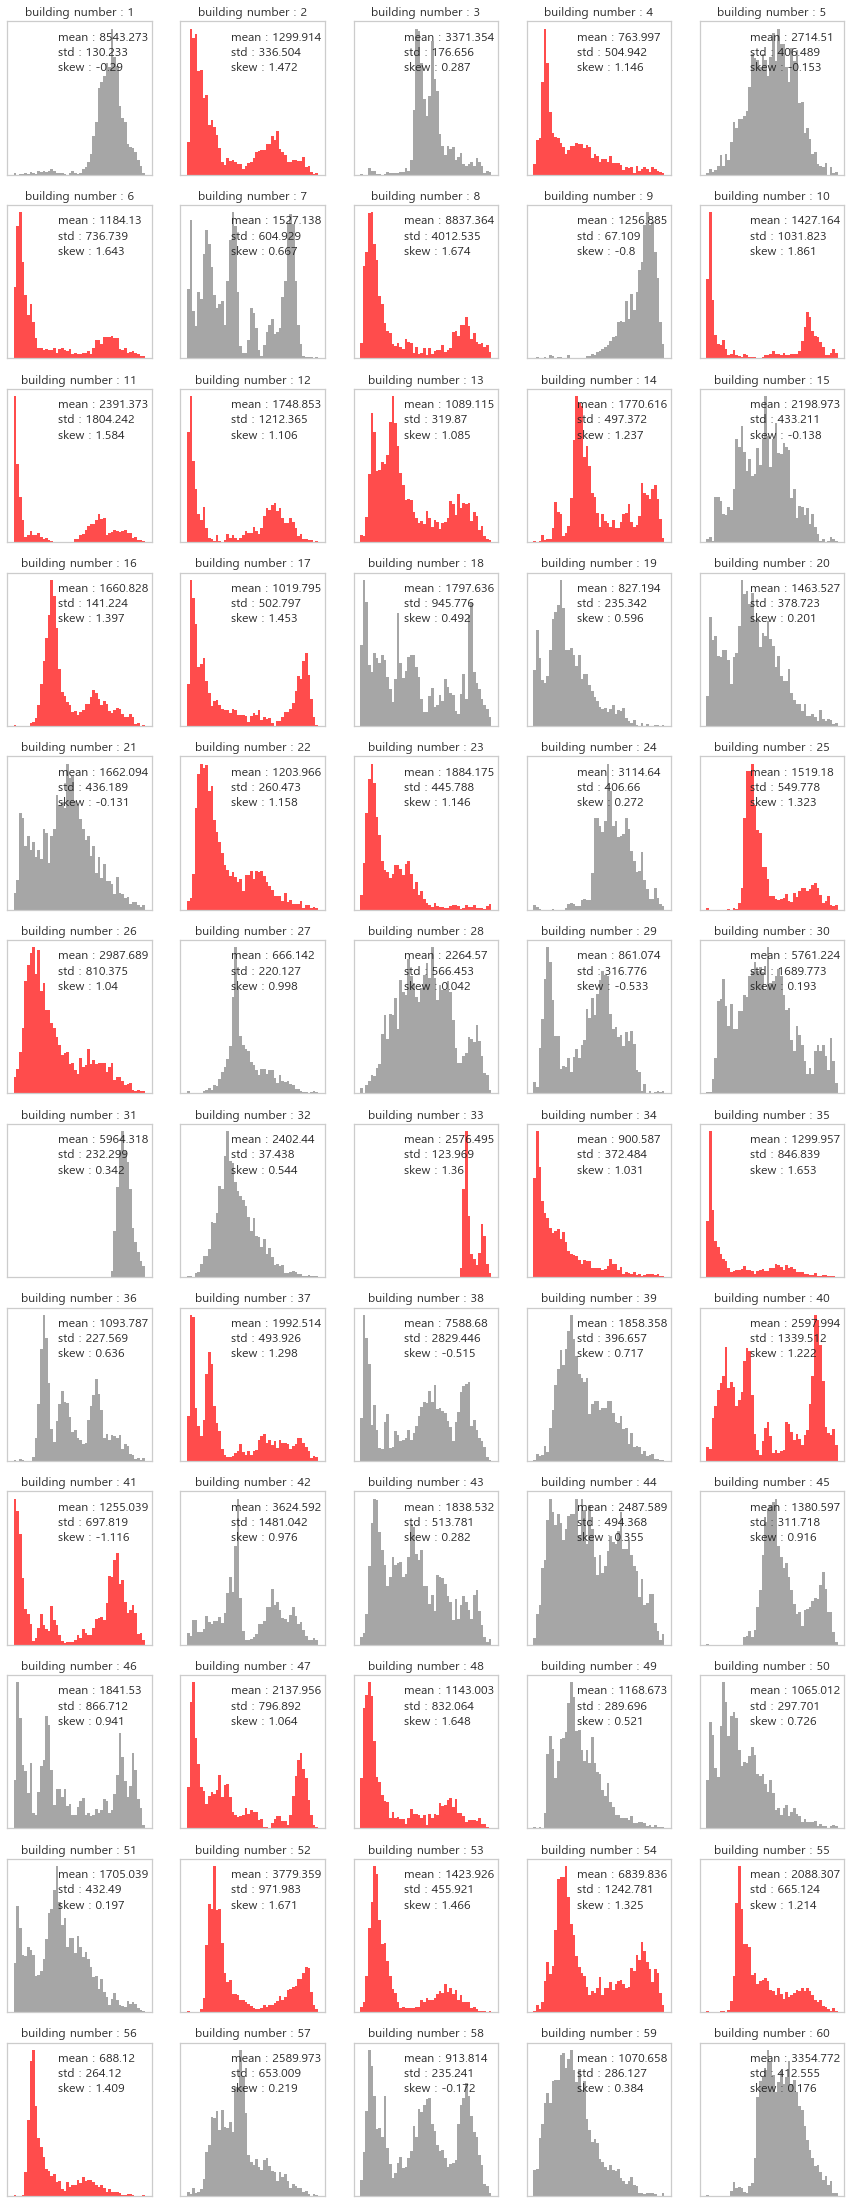

In [197]:
fig = plt.figure(figsize = (15, 40))

for num in tqdm(np.arange(1, 61)):
    ax = plt.subplot(12, 5, num)
    power = train.loc[train.num == num, 'powerconsumption'].values
    power_mean = power.mean().round(3)
    power_std = power.std().round(3)
    power_skew = (3*(power_mean - np.median(power))/power.std()).round(3)
    ## skewness as s 일때
    ## abs(s) < 0.5 : Fairy Symmetrical
    ## 0.5 <= abs(s) < 1 : Moderately Skewed
    ## abs(s) >= 1 : Highly Skewed
   
    if power_skew >= 1:
        plt.hist(power, alpha = 0.7, bins = 50, color = 'red') ## Highly Skewed
    elif power_skew <= -1:
        plt.hist(power, alpha = 0.7, bins = 50, color = 'red') ## Highly Skewed
    else:
        plt.hist(power, alpha = 0.7, bins = 50, color = 'gray') 
    plt.title('building number : {}'.format(num))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {power_mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {power_std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {power_skew}',  ha='left', va='center', transform=ax.transAxes)
    
plt.show()

60개의 건물중에서 28개의 건물의 전력사용량의 Skewness 의 절대값이 1보다 큰 것으로 확인됩니다.

모델을 만들고 fit 시에는 좋은 성능을 기대하기 위해 전력사용량 값을 log transform 을 해주도록 하겠습니다.

## 2) 일별 기온 VS 전력 사용량 추이

In [198]:
df_tmp_pw = train[['Date', 'temp','powerconsumption']]

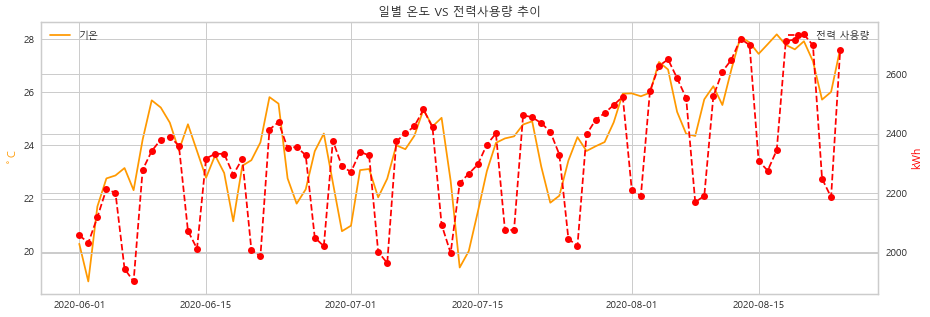

In [199]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot((df_tmp_pw.groupby(['Date'])['temp'].mean()), color = '#ff9900', label='기온')
ax1.set_ylabel('$^\circ$C', color = '#ff9900')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(df_tmp_pw.groupby(['Date'])['powerconsumption'].mean(), color = 'red', label='전력 사용량', linestyle='dashed', marker = 'o')
ax2.set_ylabel('kWh', color = 'red')
ax2.legend(loc='upper right')
plt.title("일별 온도 VS 전력사용량 추이")


plt.show()

### 위의 그래프에서 알 수 있는 점

1) 6월 ~ 8월로 갈수록 기온이 상승하는 추이를 보인다.   
2) 기온의 상승 추세와 전력사용량 사용추세는 비슷한 경향을 보인다.  
3) 전력사용량의 경우 주기적으로 낮은 사용량을 보인다. (주말 영향으로 보여진다.)

### 3) 일별 강수량 VS 전력 사용량 추이

In [20]:
df_prec_pw = train[['Date', 'precipitation','powerconsumption']]

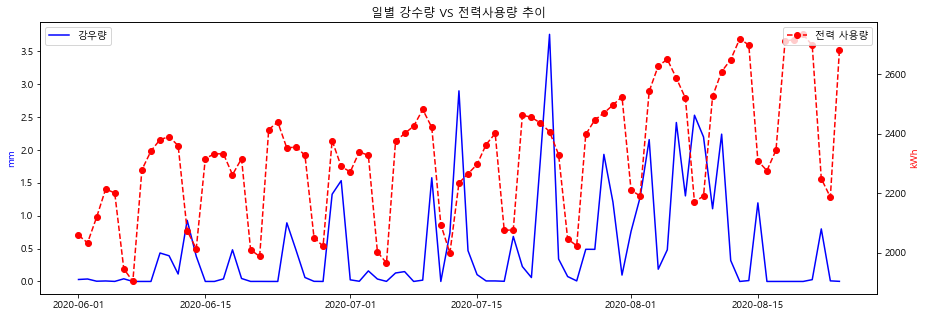

In [21]:
fig, ax4 = plt.subplots(figsize=(15,5))

ax4.plot((df_prec_pw.groupby(['Date'])['precipitation'].mean()), color = 'blue', label='강우량')
ax4.set_ylabel('mm', color = 'blue')
ax4.legend(loc='upper left')
ax5 = ax4.twinx()
ax5.plot(df_prec_pw.groupby(['Date'])['powerconsumption'].mean(), color = 'red', label='전력 사용량', linestyle='dashed', marker = 'o')
ax5.set_ylabel('kWh', color = 'red')
ax5.legend(loc='upper right')
plt.title("일별 강수량 VS 전력사용량 추이")

plt.show()

### 위 그래프에서 알 수 있는 점

1) 강수량과 전력사용량에는 큰 상관관계는 없어보인다.   
2) 7월 중순 ~ 8월 중순에 걸쳐 장마 기간이었던 것으로 보인다.  
3) 하지만, 장마기간에는 높은 습도로 인해 불쾌감이 높아질 것이며, 건물 밖으로의 이동량도 줄어 건물 내부 냉방 부하여 영향을 주었을 것이다.

In [22]:
df_prec_hum = train[['Date', 'precipitation','humidity']]

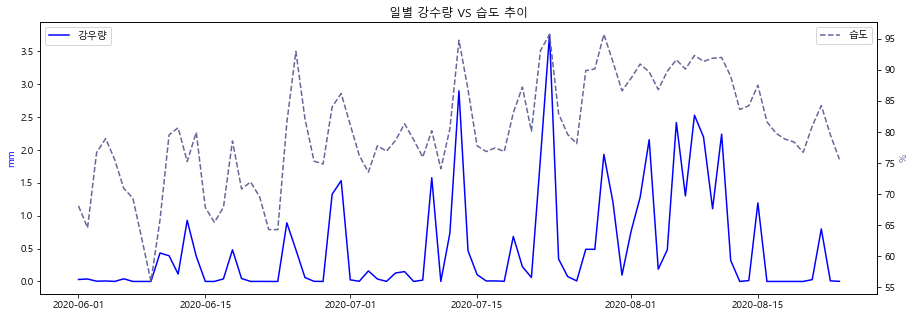

In [23]:
fig, ax6 = plt.subplots(figsize=(15,5))

ax6.plot((df_prec_hum.groupby(['Date'])['precipitation'].mean()), color = 'blue', label='강우량')
ax6.set_ylabel('mm', color = 'blue')
ax6.legend(loc='upper left')
ax7 = ax6.twinx()
ax7.plot(df_prec_hum.groupby(['Date'])['humidity'].mean(), color = '#666699', label='습도', linestyle='dashed')
ax7.set_ylabel('%', color = '#666699')
ax7.legend(loc='upper right')
plt.title("일별 강수량 VS 습도 추이")

plt.show()

### 위 그래프에서 알 수 있는 점

1) 6월 말부터 8월 말까지 일평균 75% 이상의 고습 환경이 지속된다. (일평균 습도가 70% 밑으로 떨어지지 않음)   
2) 습도가 높은 구간에서는 각 건물별로 습기 제거를 위해 공조장치의 가동률이 올라갔을 것이며, 이는 전력사용량에 영향을 주었을 것이다.

In [24]:
df_sun_pc = train[['Date', 'sunshine_hours','powerconsumption']]

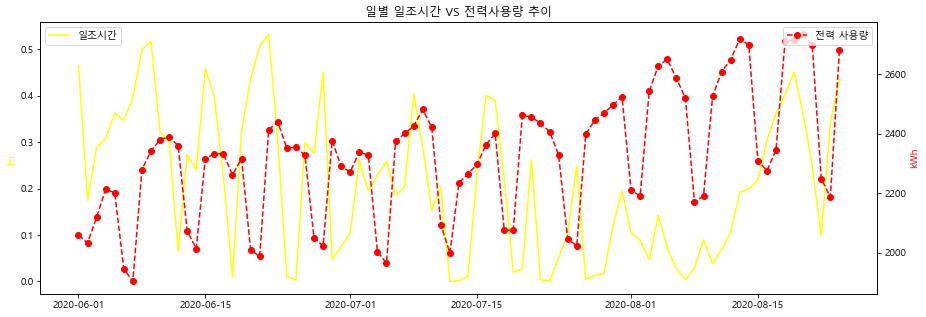

In [25]:
fig, ax8 = plt.subplots(figsize=(15,5))

ax8.plot((df_sun_pc.groupby(['Date'])['sunshine_hours'].mean()), color = '#ffff00', label='일조시간')
ax8.set_ylabel('Hr', color = '#ffff00')
ax8.legend(loc='upper left')
ax9 = ax8.twinx()
ax9.plot(df_sun_pc.groupby(['Date'])['powerconsumption'].mean(), color = 'red', label='전력 사용량', linestyle='dashed', marker = 'o')
ax9.set_ylabel('kWh', color = 'red')
ax9.legend(loc='upper right')
plt.title("일별 일조시간 VS 전력사용량 추이")

plt.show()

### 위의 그래프로 알 수 있는 점

1) 마치 일조시간이 전력사용량과 반비례 관계에 있는 것처럼 보여지지만, 실제로는 장마기간중 일조량이 낮아진 영향일 뿐이다.  
2) 일조시간과 상관없이 기온과 습도가 높아지는 7월 중순부터는 전력사용량이 증가추세를 보인다.  
3) 일조시간을 모델링 요소로 사용하는 것은 신중히 고민해야 할 것으로 보인다.  
4) 다만, 이번 데이터셋에 나오지는 않은 동절기의 경우 일조시간이 많을 경우 난방부하를 줄이는데 어느정도 영향을 주지 않을까 하는 추정이 가능하다.

## 3. Feature 별로 고민해보자

### 1) 비전력 냉방장치와 태양광 발전시설 보유 여부가 전력 사용량에 영향을 줄까?

In [10]:
temp_1 = pd.DataFrame(train.groupby(['non_elec_ac', 'solar_power'])['powerconsumption'].mean())
temp_1['percent'] = temp_1['powerconsumption'] / temp_1['powerconsumption'].sum()
temp_1

powerconsumption   percent
non_elec_ac solar_power                            
0           0                 2077.030506  0.238436
            1                 1582.298192  0.181643
1           0                 2101.993590  0.241302
            1                 2949.726621  0.338619

놀랍게도 비전력장치와 태양광설비를 모두 갖춘 경우에도 전력사용량이 높은 결과를 보여준다.

왜 그럴지 고민해보면,

1) 건물이 클 경우에는 아낀다고 아껴도 절대적인 사용량을 크게 줄일 수는 없었을지 모른다.

2) 애당초 전력 사용량이 워낙 크기 때문에 해당 설비들을 설치했을 가능성이 높다.

3) 특히 태양광 설비의 경우 일조량, 태양의 입사각 등 조건에 따라 성능 저하가 많아 생각외로 도움이 안되었을 수 있다.

4) 비전력냉방설비의 경우 가스비 상승으로 활용도가 떨어져(건물 운영 입장) 큰 역할을 못했을 수 있다.

🔔 **본 과제는 비전력장치 혹은 태양광설비 설치에 따른 전력 절감량을 구하는게 목적이 아니므로 2개의 Feature는 삭제하도록 한다.**

In [11]:
def dropBin(df):
  df.drop(columns=['non_elec_ac', 'solar_power'], inplace=True)

dropBin(train)
train.head()

num           date_time  powerconsumption  temp  windspeed  humidity  \
0    1 2020-06-01 00:00:00          8179.056  17.6        2.5      92.0   
1    1 2020-06-01 01:00:00          8135.640  17.7        2.9      91.0   
2    1 2020-06-01 02:00:00          8107.128  17.5        3.2      91.0   
3    1 2020-06-01 03:00:00          8048.808  17.1        3.2      91.0   
4    1 2020-06-01 04:00:00          8043.624  17.0        3.3      92.0   

   precipitation  sunshine_hours  Dow  Hour        Date  
0            0.8             0.0    0     0  2020-06-01  
1            0.3             0.0    0     1  2020-06-01  
2            0.0             0.0    0     2  2020-06-01  
3            0.0             0.0    0     3  2020-06-01  
4            0.0             0.0    0     4  2020-06-01

### 2) 건물별로 각 특성들이 다를까?

가) 각 건물별로 시간대별 전력사용량을 그려보고 패턴이 있을지 확인해보자

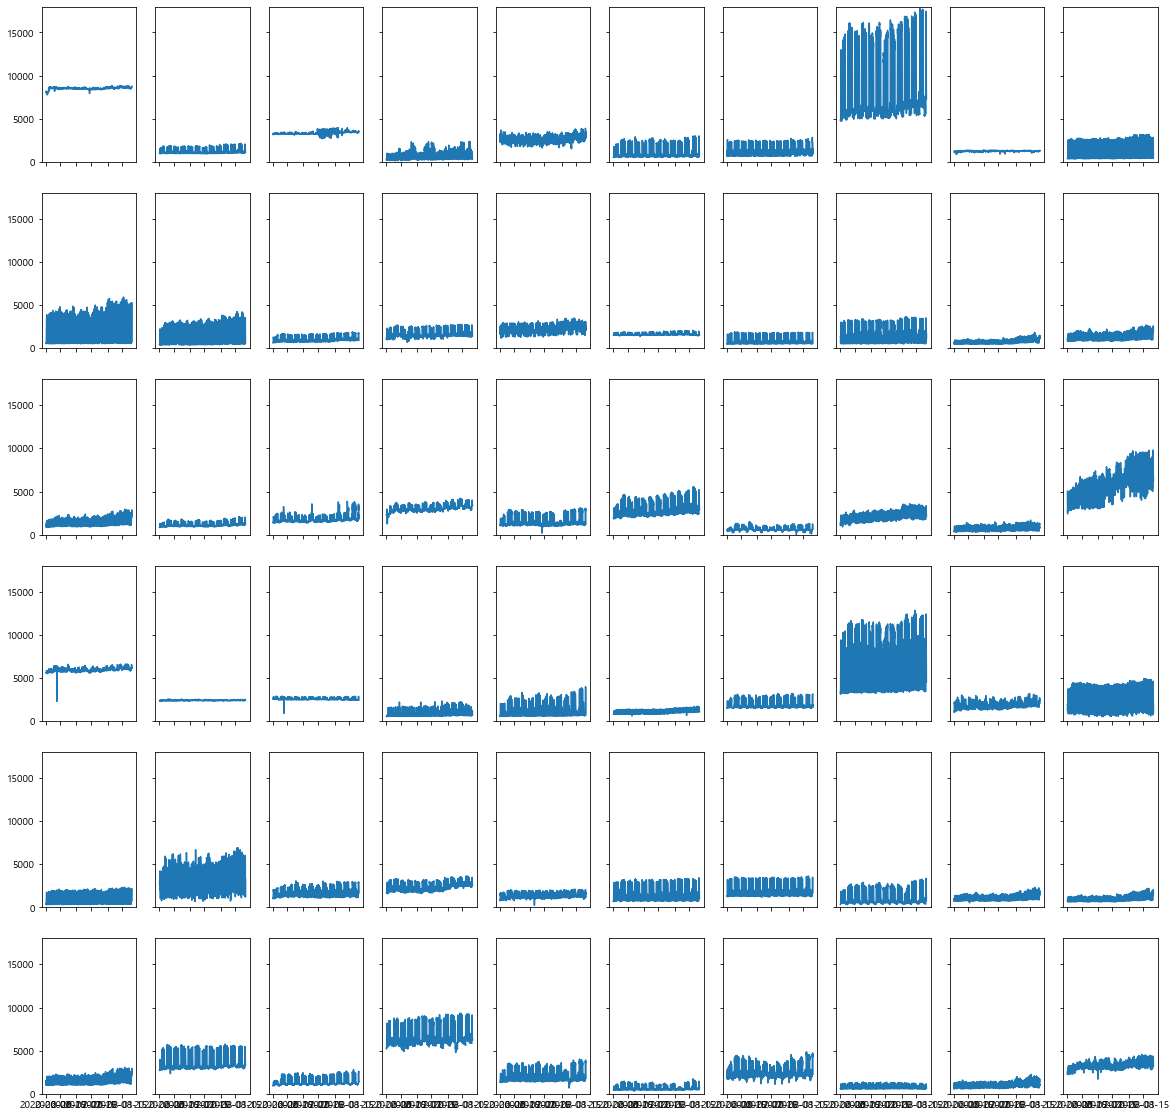

In [28]:
def myPlot_time(df):
  df_copy = df.copy()
  df_copy = df_copy.sort_values(by=['num','date_time'])
  
  fig, ax = plt.subplots(6,10, figsize=(20,20), sharey=True, sharex=True)

  for i in range(0,6):
    for j in range(0,10):
      bldg_num = i * 10 + j + 1
      ax[i][j].plot('date_time','powerconsumption', data = train[train['num']==bldg_num])

  plt.ylim((0,18000))
  plt.show()
  
myPlot_time(train)

**각 건물별로 시간대별 전력 사용량의 패턴이 비슷한 그룹이 있는 것으로 보여진다.**

**나) 건물별로 주어진 데이터의 숫자형 feature 와의 상관관계를 살펴보자**

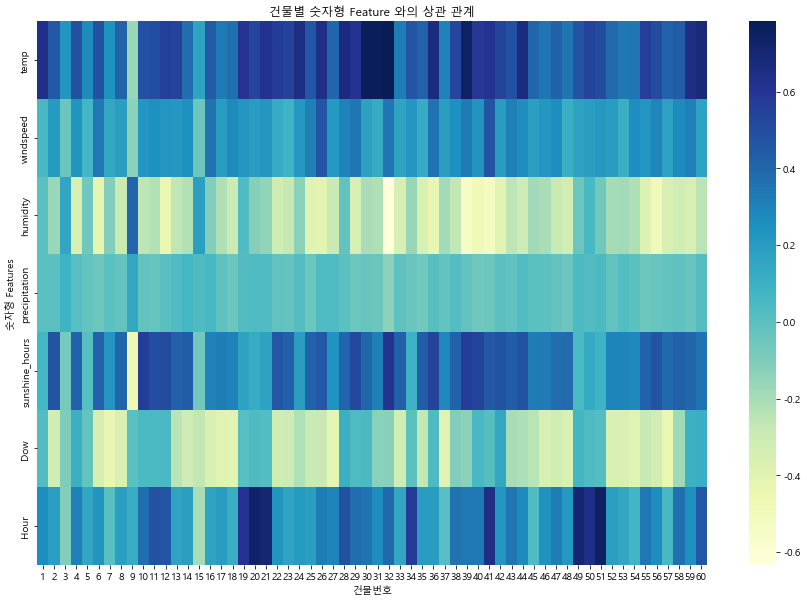

In [29]:
def myCorr(df):
    corr=[]
    
    for i in range(1,61):
        temp = df[df['num'] == i]
        corrs = temp.corr()['powerconsumption']    
        corr.append(corrs)
    
    corr_df = pd.concat(corr, axis=1).T
    corr_df.index = list(np.arange(1,61,1))
    corr_df.drop(columns=['num', 'powerconsumption'], inplace=True)
    return corr_df

fig, ax = plt.subplots(figsize=(15,10))
plt.title("건물별 숫자형 Feature 와의 상관 관계")
sns.heatmap(myCorr(train).T, cmap="YlGnBu", ax=ax)
plt.xlabel('건물번호')
plt.ylabel('숫자형 Features')
plt.show()

직과적으로 봤을때 몇개의 그룹이 보여집니다.

1, 30, 31, 32 , 39 등의 건물은 온도와 강한 양의 상관 관계를 갖고

19, 20, 23, 49, 50, 51 등의 건물은 시간대와 강한 양의 상관관계를 보이며,

9번 건물은 특이하게 습도와 강한 양의 상관 관계를 보여줍니다.

Heatmap 으로 건물별로 전력사용량에 영향을 주는 인자가 다르다는 것을 확인하였습니다.

점점 건물별 혹은 유사건물들을 묶은 그룹별 모델을 개발하는 것이 타당할 것이라는 결론으로 나아갑니다.

### 3) 온도, 습도, 바람의 영향을 대표하는 지수를 반영해봅니다.

> - 체감온도 (Wind Chilling Temperature) = 13.2 + 0.6215 * T - 11.37 * V^0.16 + 0.3965 * V^0.16 * T  
>           (T = 기온(도씨), V = 지상 풍속(km/h)  
>
> - 열지수 (Heat Index) : 체감온도에 습도의 영향을 반영, 습도 50%를 기준으로 10% 늘거나 줄때마다 온도가 1도씩 늘거나 줄어든다.  


* 체감온도는 주로 동절기에 적용하고, 열지수는 하절기에 적용한다. (미국 기상청 채택)  
  따라서 본과제는 하절기 대상이므로 열지수를 선택한다.
* 2020년 여름 이전까지 우리나라 기상청에서는 불쾌지수를 제공했으나,  
  2020년 여름부터는 미국 기상청을 따라 열지수를 기준으로 폭염경보, 폭염주의보 등을 발령하고 있다.

In [201]:
def myWindChill(df):
    df['WC'] = 13.2 + 0.6215 * df['temp'] - 11.37 * ((df['windspeed'] * 3.6) ** 0.16) + 0.3965 * ((df['windspeed']*3.6) ** 0.16) * df['temp']
    
    df['HI'] = df['WC']
    
    df['HI'] = np.where((df['humidity'] <= 20) & (df['humidity'] > 10), df['HI'].add(-3), df['HI'])
    df['HI'] = np.where((df['humidity'] <= 30) & (df['humidity'] > 20), df['HI'].add(-2), df['HI'])
    df['HI'] = np.where((df['humidity'] <= 40) & (df['humidity'] > 30), df['HI'].add(-1), df['HI'])
    df['HI'] = np.where((df['humidity'] < 60) & (df['humidity'] > 40), df['HI'].add(0), df['HI'])
    df['HI'] = np.where((df['humidity'] < 70) & (df['humidity'] >= 60), df['HI'].add(1), df['HI'])
    df['HI'] = np.where((df['humidity'] < 80) & (df['humidity'] >= 70), df['HI'].add(2), df['HI'])
    df['HI'] = np.where((df['humidity'] < 90) & (df['humidity'] >= 80), df['HI'].add(3), df['HI'])
    df['HI'] = np.where((df['humidity'] < 100) & (df['humidity'] >= 90), df['HI'].add(4), df['HI'])
    df['HI'] = np.where((df['humidity'] == 100), df['HI'].add(4), df['HI'])
    
    df.drop(columns = ['WC'], inplace=True)

In [202]:
myWindChill(train)
train

num           date_time  powerconsumption  temp  windspeed  humidity  \
0         1 2020-06-01 00:00:00          8179.056  17.6        2.5      92.0   
1         1 2020-06-01 01:00:00          8135.640  17.7        2.9      91.0   
2         1 2020-06-01 02:00:00          8107.128  17.5        3.2      91.0   
3         1 2020-06-01 03:00:00          8048.808  17.1        3.2      91.0   
4         1 2020-06-01 04:00:00          8043.624  17.0        3.3      92.0   
...     ...                 ...               ...   ...        ...       ...   
122395   60 2020-08-24 19:00:00          4114.368  27.8        2.3      68.0   
122396   60 2020-08-24 20:00:00          3975.696  27.3        1.2      71.0   
122397   60 2020-08-24 21:00:00          3572.208  27.3        1.8      71.0   
122398   60 2020-08-24 22:00:00          3299.184  27.1        1.8      74.0   
122399   60 2020-08-24 23:00:00          3204.576  27.1        2.6      75.0   

        precipitation  sunshine_hours  Dow  Hour        Date         HI  
0                 0.8             0.0    0     0  2020-06-01  21.896719  
1                 0.3             0.0    0     1  2020-06-01  21.866580  
2                 0.0             0.0    0     2  2020-06-01  21.524480  
3                 0.0             0.0    0     3  2020-06-01  21.041384  
4                 0.0             0.0    0     4  2020-06-01  20.886826  
...               ...             ...  ...   ...         ...        ...  
122395            0.0             0.7    0    19  2020-08-24  30.990632  
122396            0.0             0.0    0    20  2020-08-24  31.477485  
122397            0.0             0.0    0    21  2020-08-24  31.431274  
122398            0.0             0.0    0    22  2020-08-24  31.200038  
122399            0.0             0.0    0    23  2020-08-24  31.148974  

[122400 rows x 12 columns]

>기상청에서는 아래와 같이 체감온도에 따른 위험 단계를 매해 발령하고 있습니다.
>
>위험 단계 컬럼을 새로 추가해 봅니다.

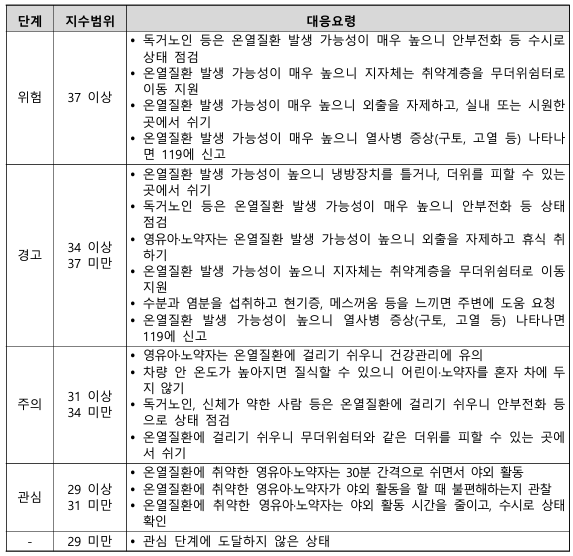

In [203]:
def myGrade(df):
    df['temp_grade'] = None
    
    ## Normal : 0, attention : 1, caution : 2, warning : 3, danger : 4
    
    df['temp_grade'] = np.where((df['HI'] < 29), 0, df['temp_grade'])
    df['temp_grade'] = np.where((df['HI'] < 31) & (df['HI'] >= 29), 1, df['temp_grade'])
    df['temp_grade'] = np.where((df['HI'] < 34) & (df['HI'] >= 31), 2, df['temp_grade'])
    df['temp_grade'] = np.where((df['HI'] < 37) & (df['HI'] >= 34), 3, df['temp_grade'])
    df['temp_grade'] = np.where((df['HI'] >= 37), 4, df['temp_grade'])

In [204]:
myGrade(train)
train

num           date_time  powerconsumption  temp  windspeed  humidity  \
0         1 2020-06-01 00:00:00          8179.056  17.6        2.5      92.0   
1         1 2020-06-01 01:00:00          8135.640  17.7        2.9      91.0   
2         1 2020-06-01 02:00:00          8107.128  17.5        3.2      91.0   
3         1 2020-06-01 03:00:00          8048.808  17.1        3.2      91.0   
4         1 2020-06-01 04:00:00          8043.624  17.0        3.3      92.0   
...     ...                 ...               ...   ...        ...       ...   
122395   60 2020-08-24 19:00:00          4114.368  27.8        2.3      68.0   
122396   60 2020-08-24 20:00:00          3975.696  27.3        1.2      71.0   
122397   60 2020-08-24 21:00:00          3572.208  27.3        1.8      71.0   
122398   60 2020-08-24 22:00:00          3299.184  27.1        1.8      74.0   
122399   60 2020-08-24 23:00:00          3204.576  27.1        2.6      75.0   

        precipitation  sunshine_hours  Dow  Hour        Date         HI  \
0                 0.8             0.0    0     0  2020-06-01  21.896719   
1                 0.3             0.0    0     1  2020-06-01  21.866580   
2                 0.0             0.0    0     2  2020-06-01  21.524480   
3                 0.0             0.0    0     3  2020-06-01  21.041384   
4                 0.0             0.0    0     4  2020-06-01  20.886826   
...               ...             ...  ...   ...         ...        ...   
122395            0.0             0.7    0    19  2020-08-24  30.990632   
122396            0.0             0.0    0    20  2020-08-24  31.477485   
122397            0.0             0.0    0    21  2020-08-24  31.431274   
122398            0.0             0.0    0    22  2020-08-24  31.200038   
122399            0.0             0.0    0    23  2020-08-24  31.148974   

       temp_grade  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
122395          1  
122396          2  
122397          2  
122398          2  
122399          2  

[122400 rows x 13 columns]

### 4) 냉방에 따른 에너지 부하 증가여부를 알 수 있는 지수를 반영해봅니다.

>냉방도일 : Cooling Degree Day 
 
* 본 dataset 에서는 매 시간별로 데이터가 나누어져 있으므로 1시간 단위로 Cooling Degree Hour 로 변환해 구해본다.
* 평형점 온도는 대부분의 건물에서 하절기 관리 온도 기준으로 삼는 24도씨로 한다.

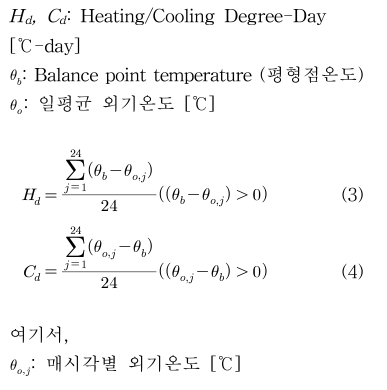

In [205]:
def myCDH(bldg_temps):
    results = []
    bpt = 24

    for i in range(len(bldg_temps)):
        diff = bldg_temps[(bldg_temps.index[0] + i)] - bpt
    
        if diff > 0:
            diff = 1
        else:
            diff = 0
    
        results.append(np.sum(bldg_temps[(i//24)*24:i+1]-24)/(i%24+1)*diff)
    return np.array(results)

In [206]:
cdhs = np.array([])
for num in tqdm(np.arange(1,61)):
    temp = train[train['num'] == num]
    cdh = myCDH(temp['temp'])
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:41<00:00,  1.44it/s]


**4-1) 각 건물별로 CDH 추이를 살펴 보자**

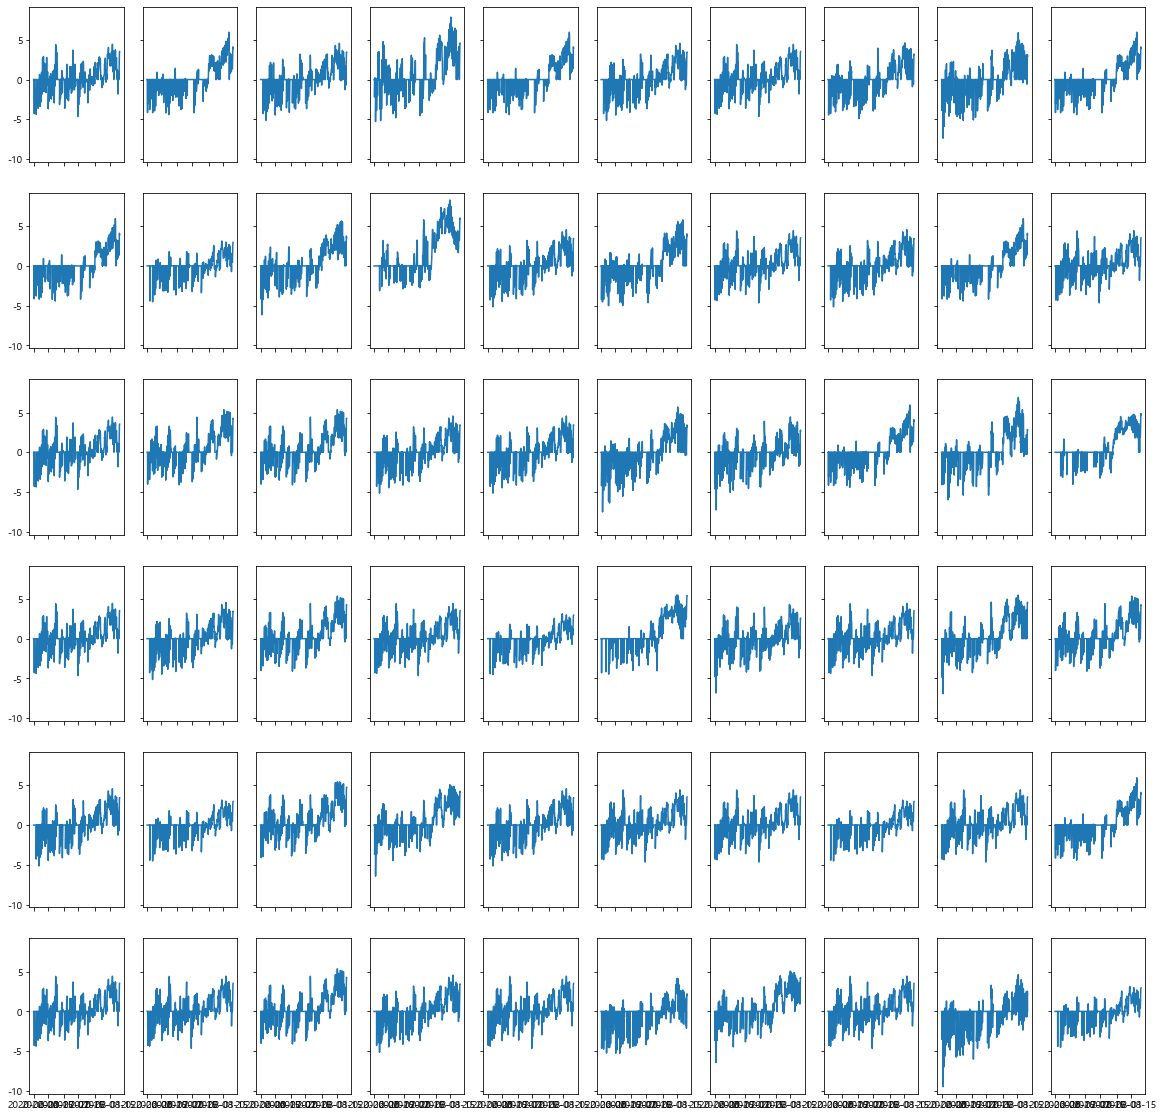

In [36]:
def myPlot_CDH(df):
  df_copy = df.copy()
  df_copy = df_copy.sort_values(by=['num','date_time'])
  
  fig, ax = plt.subplots(6,10, figsize=(20,20), sharey=True, sharex=True)

  for i in range(0,6):
    for j in range(0,10):
      bldg_num = i * 10 + j + 1
      ax[i][j].plot('date_time','CDH', data = train[train['num']==bldg_num])

  plt.show()
  
myPlot_CDH(train)

**위의 그래프를 보고 읽어낼 수 있는 사항들은 다음과 같다.**

가) CDH 값이 0보다 큰 날 수가 많은 건물일 수록 냉방 부하가 큰 날 수가 많다.  
나) CDH 값이 계속 양수인 건물이 많은 날은 전력 공급 입장에서 공급 부하가 클 것이다.   
다) 2, 5, 10, 11, 38 번 건물 등의 패턴은 6, 7 월까지는 크게 냉방부하가 없다가 8월 이후 증가하는 모습을 보이며,  
    그외의 건물들은 6월부터 냉방부하가 나타나는 모습을 보인다.

### 5) Clustering

Feature 별 특성을 살펴볼때 기술한바와 같이 전력사용량이 비슷한 패턴을 보이는 건물들끼리 묶어주는 작업을 해봅니다.

KMeans Clustering 을 활용해 묶어봅니다.

In [207]:
train_copy = train.copy()

In [208]:
by_dow = train_copy.groupby(['num','Dow'])['powerconsumption'].median().reset_index().pivot(index = 'num', columns = 'Dow', values = 'powerconsumption').reset_index()
by_hour = train.groupby(['num','Hour'])['powerconsumption'].median().reset_index().pivot(index = 'num',columns = 'Hour',values = 'powerconsumption').reset_index().drop('num', axis = 1)
df = pd.concat([by_dow, by_hour], axis= 1)
columns = ['num'] + [str(i) for i in range(7)] + [str(i) for i in range(24)]
df.columns = columns

In [209]:
# standard scaling
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

In [210]:
df.head()

num         0         1         2         3         4         5         6  \
0    1  0.590985 -0.087195  0.675757  1.048756  0.455349 -0.968828 -1.714825   
1    2  0.259920  0.635967  0.633139  0.760373  0.600624 -1.367257 -1.522765   
2    3  0.530408  0.226509  0.740475  0.761071  0.619469 -1.352837 -1.525096   
3    4 -1.280487 -0.973568 -0.771281  0.156449  1.105105  0.791211  0.972572   
4    5  0.378345  0.055196  0.034121 -0.827608  1.666255  0.223795 -1.530104   

          0         1  ...        14        15        16        17        18  \
0 -0.054554 -0.495728  ...  1.126655  1.283201  1.254738  1.098192  0.600092   
1 -1.031987 -1.053854  ...  1.112910  1.081104  1.069177  0.851507  0.069285   
2 -1.199306 -1.253455  ...  1.273898  1.204446  1.663537  1.416334  0.093211   
3 -0.904856 -0.950505  ...  1.471105  1.454404  1.320798  1.024638  0.499121   
4  0.966190  0.691945  ... -0.306662 -0.179973 -0.467631 -0.577925 -1.293345   

         19        20        21        22        23  
0  0.813564  0.543166  0.628555  0.628555  0.215843  
1 -0.428673 -0.675167 -0.815311 -0.937564 -0.992230  
2 -0.749632 -0.853222 -1.010961 -1.006252 -0.050402  
3  0.062674 -0.406060 -0.629851 -0.821353 -0.776817  
4  0.238846  1.422270  1.352218  1.283657  1.012394  

[5 rows x 32 columns]

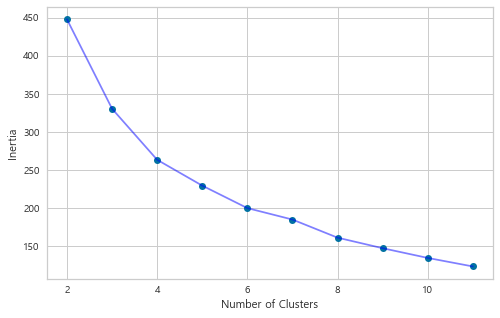

In [211]:
# elbow method를 통해 군집의 개수 결정
def myElbow_plot(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5, color='blue')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

myElbow_plot([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

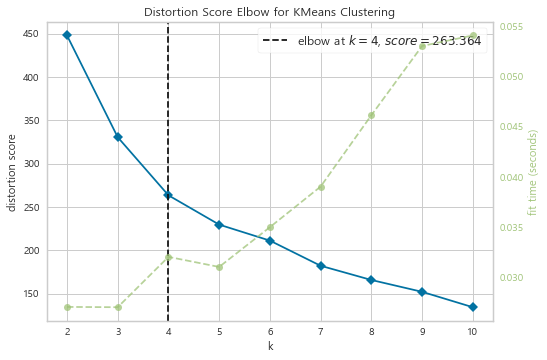

In [212]:
# yellowbrick Library의 elbow method를 통해 군집의 개수 확인

def myElbow_plot(data):
    km = KMeans()
    visualizer = KElbowVisualizer(km, k=(2,11))
    visualizer.fit(data)
    visualizer.poof()

myElbow_plot(df.iloc[:,1:])

군집화가 얼마나 잘되었는지 확인하는 silhouette score 도 구해봅니다.  

0에 가까울수록 군집끼리 겹쳐있는 정도가 많은 것이고, 1에 가까울수록 군집끼리 겹치지 않고 잘 분류되어 있는 것입니다.

In [213]:
df_clust = df.copy()
for n in range(3,7):
    kmeans = KMeans(n_clusters=n, random_state=42)
    km_cluster = kmeans.fit_predict(df.iloc[:,1:38])
    df_clust['km_cluster({})'.format(n)] = km_cluster

In [214]:
score_dow = {3:0, 4:0, 5:0, 6:0}
score_day = {3:0, 4:0, 5:0, 6:0}
for n in range(3,7):
    score_dow[n] = round(silhouette_score(df_clust.iloc[:,1:8], df_clust['km_cluster({})'.format(n)], metric='euclidean'),3)
    score_day[n] = round(silhouette_score(df_clust.iloc[:,8:32], df_clust['km_cluster({})'.format(n)], metric='euclidean'),3)

In [215]:
print(score_dow)
print(score_day)

{3: 0.519, 4: 0.405, 5: 0.3, 6: -0.07}
{3: 0.201, 4: 0.227, 5: 0.232, 6: 0.249}


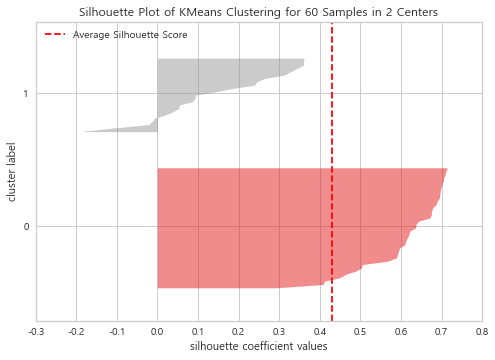

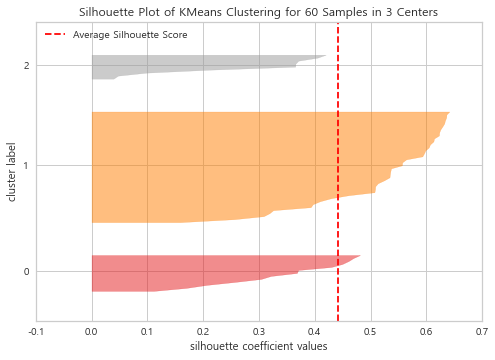

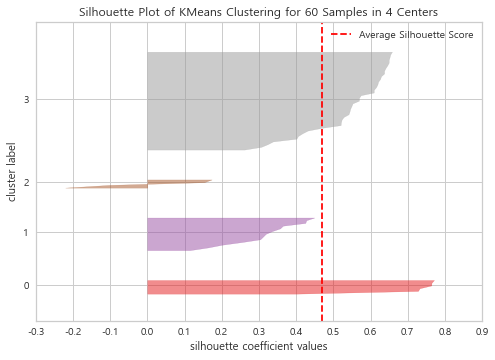

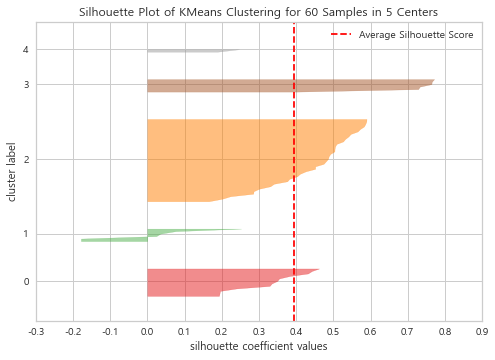

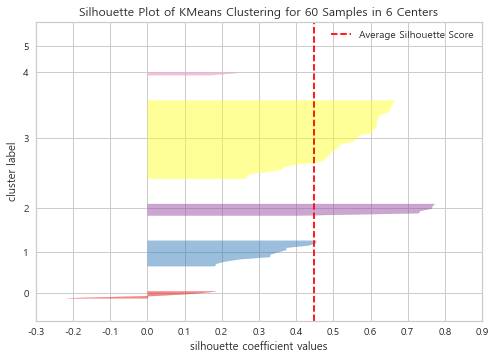

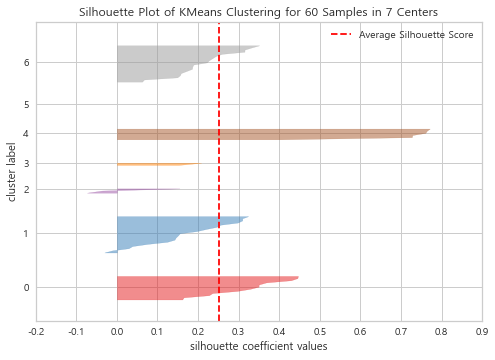

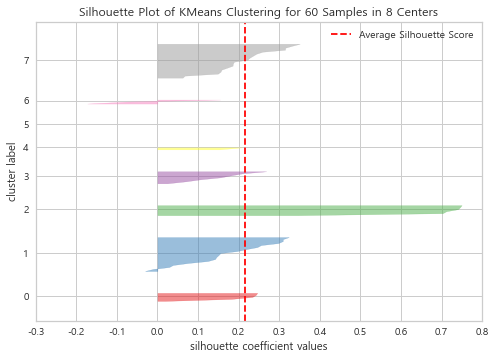

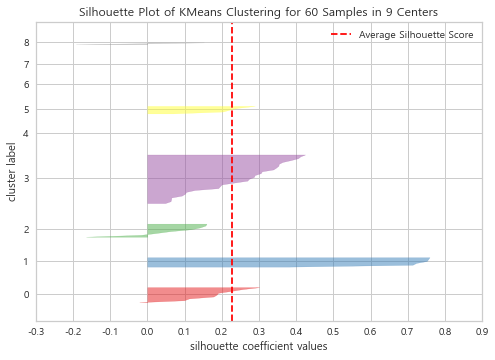

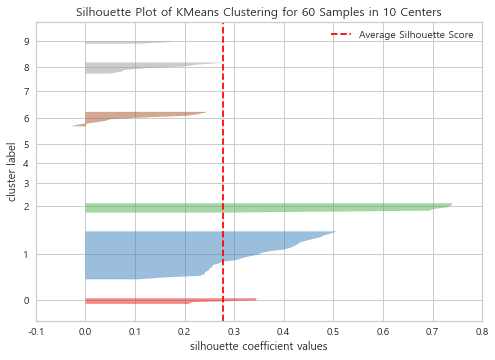

In [216]:
k_range = range(2,11)

for i in k_range:
   km = KMeans(n_clusters = i)
   visualizer = SilhouetteVisualizer(km)
   visualizer.fit(df.iloc[:,1:])
   visualizer.poof()

요일과 시간 두가지 경우 골고루 높게 나온 k=4 로 선택한 것이 나쁘지 않아보입니다.

k = 4 일 경우 시간별 평균 전력사용량과, 요일별 평균 전력사용량을 시각화해봅니다.

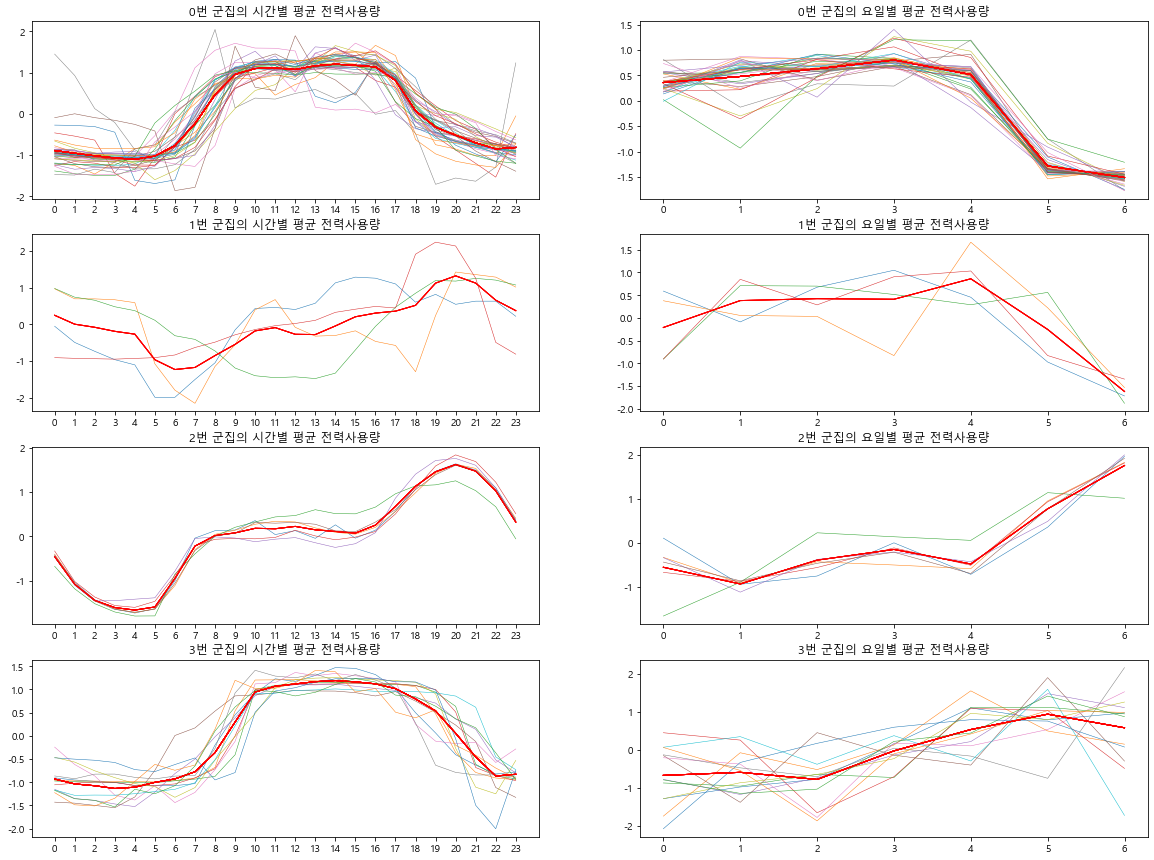

In [45]:
# visualizing result of kmeans(4) clustering
n_c = len(np.unique(df_clust['km_cluster(4)'])) 

fig = plt.figure(figsize = (20,15))

for c in range(n_c):
    temp = df_clust[df_clust['km_cluster(4)'] == c]
        
    ## 시간별 전력 Plot
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:32], linewidth=0.5)
        plt.plot(temp.iloc[:,8:32].mean(), linewidth=1, color='red')
        plt.title('{}번 군집의 시간별 평균 전력사용량'.format(c))
        plt.xlabel('')

    
    ## 요일별 전력 Plot
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.5)
        plt.plot(temp.iloc[:,1:8].mean(), linewidth=1, color='red')
        plt.title('{}번 군집의 요일별 평균 전력사용량'.format(c))
        plt.xlabel('')


In [217]:
train_clustered = train.merge(df_clust[['num', 'km_cluster(4)']], on='num', how='left')

In [218]:
train_clustered.head()

num           date_time  powerconsumption  temp  windspeed  humidity  \
0    1 2020-06-01 00:00:00          8179.056  17.6        2.5      92.0   
1    1 2020-06-01 01:00:00          8135.640  17.7        2.9      91.0   
2    1 2020-06-01 02:00:00          8107.128  17.5        3.2      91.0   
3    1 2020-06-01 03:00:00          8048.808  17.1        3.2      91.0   
4    1 2020-06-01 04:00:00          8043.624  17.0        3.3      92.0   

   precipitation  sunshine_hours  Dow  Hour        Date         HI temp_grade  \
0            0.8             0.0    0     0  2020-06-01  21.896719          0   
1            0.3             0.0    0     1  2020-06-01  21.866580          0   
2            0.0             0.0    0     2  2020-06-01  21.524480          0   
3            0.0             0.0    0     3  2020-06-01  21.041384          0   
4            0.0             0.0    0     4  2020-06-01  20.886826          0   

   CDH  km_cluster(4)  
0 -0.0              1  
1 -0.0              1  
2 -0.0              1  
3 -0.0              1  
4 -0.0              1

In [219]:
match = df_clust[['num','km_cluster(4)']]
clust_to_num = {0:[],1:[],2:[],3:[]}
for i in range(60):
    c = match.iloc[i,1]
    clust_to_num[c].append(i+1)

In [220]:
for i in range(4):
    print('Group {0} : {1}'.format(i, clust_to_num[i]))

Group 0 : [2, 3, 6, 7, 8, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 27, 31, 32, 33, 35, 37, 38, 39, 43, 44, 45, 46, 47, 48, 52, 53, 54, 55, 56, 57, 58]
Group 1 : [1, 5, 9, 34]
Group 2 : [19, 20, 21, 49, 50, 51]
Group 3 : [4, 10, 11, 12, 28, 29, 30, 36, 40, 41, 42, 59, 60]


## 4. Modeling

### 1) Baseline Model

- 본 데이터 셋의 Target 은 전력사용량을 예측하는 것이므로 회귀모델을 적용합니다.  
- 본격적인 회귀 모델 선정에 앞서 비교 기준을 위한 Baseline model 을 선정합니다.  

In [221]:
baseline_model = train['powerconsumption'].mean()
baseline_model

2324.8308658684296

<function matplotlib.pyplot.show(close=None, block=None)>

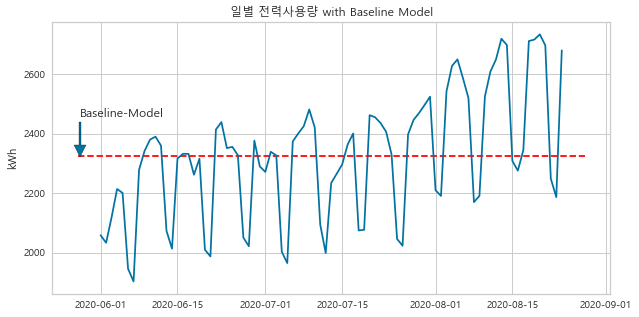

In [222]:
fig, ax10 = plt.subplots(figsize=(10,5))

ax10.plot(train.groupby(['Date'])['powerconsumption'].mean())
ax10.set_ylabel('kWh')
xmin, xmax = plt.xlim()
plt.hlines(baseline_model, xmin, xmax, color='red', linestyle='dashed')
ax10.annotate('Baseline-Model', xy=(80,160), xytext = (80,200), xycoords='figure points', arrowprops=dict(width=2))

plt.title("일별 전력사용량 with Baseline Model")
plt.show

### 2) 학습 모델 선택 : 트리기반의 XGBoostRegressor 를 선택하여 진행합니다.

In [223]:
df_temp = train_clustered.copy()
df_temp['temp_grade'] = df_temp['temp_grade'].astype('int')
X_temp = [df_temp[df_temp.num == num] for num in range(1,61,1)]

In [53]:
## 최적 파라미터를 저장하기 위한 Dataframe을 만듭니다.

'''
param = pd.DataFrame(np.zeros(60))
param.columns = ['n_estimators']
param['learning_rate'] = 0
param['max_depth'] = 0
param['subsamples'] = 0
'''

"\nparam = pd.DataFrame(np.zeros(60))\nparam.columns = ['n_estimators']\nparam['learning_rate'] = 0\nparam['max_depth'] = 0\nparam['subsamples'] = 0\n"

In [224]:
## 각 건물별 모델을 만들어준다. (하이퍼파라미터는 기본값)

xgbrs = [XGBRegressor(random_state=42) for i in range(60)]

In [49]:
## 60개 건물들의 하이퍼 파라미터를 튜닝해준다.
## Score = nrmse
## 시간상의 이유로 CV = 5로 고정
## early_stopping_rouns = 30 으로 설정하고 GridSearchCV 사용
## 60개 건물에 대해 모두 실행하는데 약 3시간 소요됨 (with Junpiternotebook)

'''
for i in tqdm(np.arange(0,60)):
    y = X_temp[i-1]['powerconsumption']
    y = np.log1p(y)
    X = X_temp[i-1].iloc[:,3:]
    X.drop(columns=['Date'],inplace=True)
    
    ## Train Set 는 55일, Valid set 는 13일, Test Set는 17일로 한다.
    ## Train : 24시간 * 55일 = 1320
    ## Valid : 24시간 * 13일 = 312
    ## Test : 24시간 * 17일 = 408
    X_train = X.iloc[:1320,:]
    X_valid = X.iloc[1320:1632,:]
    X_test = X.iloc[1632:,:]
    y_train = y.iloc[:1320]
    y_valid = y.iloc[1320:1632]
    y_test = y.iloc[1632:]

    xgbr_param = {
            'n_estimators' : [100,150],
            'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.40, 0.45, 0.50],
            'max_depth': [3, 5, 7, 9, 11],
            'subsample' : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0] }
    
    grid_xgbr = GridSearchCV(xgbrs[i-1], param_grid=xgbr_param, cv=5, scoring = 'neg_root_mean_squared_error', n_jobs=-1)
    grid_xgbr.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=30)

    best_NE = grid_xgbr.best_params_['n_estimators']
    best_LR = grid_xgbr.best_params_['learning_rate']
    best_MD = grid_xgbr.best_params_['max_depth']
    best_SS = grid_xgbr.best_params_['subsample']
    
    xgbrs[i-1] = grid_xgbr.best_estimator_
    
    param.iloc[i-1,0] = best_NE
    param.iloc[i-1,1] = best_LR
    param.iloc[i-1,2] = best_MD
    param.iloc[i-1,3] = best_SS
'''

[0]	validation_0-rmse:7.27729
[1]	validation_0-rmse:6.91774
[2]	validation_0-rmse:6.57645
[3]	validation_0-rmse:6.25233
[4]	validation_0-rmse:5.94416
[5]	validation_0-rmse:5.65142
[6]	validation_0-rmse:5.37325
[7]	validation_0-rmse:5.10893
[8]	validation_0-rmse:4.85795
[9]	validation_0-rmse:4.61950
[10]	validation_0-rmse:4.39310
[11]	validation_0-rmse:4.17785
[12]	validation_0-rmse:3.97354
[13]	validation_0-rmse:3.77948
[14]	validation_0-rmse:3.59494
[15]	validation_0-rmse:3.41975
[16]	validation_0-rmse:3.25330
[17]	validation_0-rmse:3.09486
[18]	validation_0-rmse:2.94465
[19]	validation_0-rmse:2.80186
[20]	validation_0-rmse:2.66624
[21]	validation_0-rmse:2.53744
[22]	validation_0-rmse:2.41492
[23]	validation_0-rmse:2.29844
[24]	validation_0-rmse:2.18801
[25]	validation_0-rmse:2.08279
[26]	validation_0-rmse:1.98305
[27]	validation_0-rmse:1.88831
[28]	validation_0-rmse:1.79821
[29]	validation_0-rmse:1.71244
[30]	validation_0-rmse:1.63127
[31]	validation_0-rmse:1.55403
[32]	validation_0-

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[59]	validation_0-rmse:0.41589
[60]	validation_0-rmse:0.39842
[61]	validation_0-rmse:0.38177
[62]	validation_0-rmse:0.36586
[63]	validation_0-rmse:0.35038
[64]	validation_0-rmse:0.33586
[65]	validation_0-rmse:0.32059
[66]	validation_0-rmse:0.30739
[67]	validation_0-rmse:0.29481
[68]	validation_0-rmse:0.28308
[69]	validation_0-rmse:0.27164
[70]	validation_0-rmse:0.26116
[71]	validation_0-rmse:0.25005
[72]	validation_0-rmse:0.23917
[73]	validation_0-rmse:0.23004
[74]	validation_0-rmse:0.22147
[75]	validation_0-rmse:0.21346
[76]	validation_0-rmse:0.20600
[77]	validation_0-rmse:0.19768
[78]	validation_0-rmse:0.19010
[79]	validation_0-rmse:0.18354
[80]	validation_0-rmse:0.17604
[81]	validation_0-rmse:0.17018
[82]	validation_0-rmse:0.16436
[83]	validation_0-rmse:0.15827
[84]	validation_0-rmse:0.15328
[85]	validation_0-rmse:0.14849
[86]	validation_0-rmse:0.14399
[87]	validation_0-rmse:0.13974
[88]	validation_0-rmse:0.13558
[89]	validation_0-rmse:0.13147
[90]	validation_0-rmse:0.12788
[91]	val

[73]	validation_0-rmse:0.04320
[74]	validation_0-rmse:0.04301
[75]	validation_0-rmse:0.04271
[76]	validation_0-rmse:0.04257
[77]	validation_0-rmse:0.04252
[78]	validation_0-rmse:0.04238
[79]	validation_0-rmse:0.04212
[80]	validation_0-rmse:0.04200
[81]	validation_0-rmse:0.04182
[82]	validation_0-rmse:0.04180
[83]	validation_0-rmse:0.04169
[84]	validation_0-rmse:0.04157
[85]	validation_0-rmse:0.04116
[86]	validation_0-rmse:0.04119
[87]	validation_0-rmse:0.04099
[88]	validation_0-rmse:0.04098
[89]	validation_0-rmse:0.04081
[90]	validation_0-rmse:0.04104
[91]	validation_0-rmse:0.04101
[92]	validation_0-rmse:0.04099
[93]	validation_0-rmse:0.04089
[94]	validation_0-rmse:0.04088
[95]	validation_0-rmse:0.04079
[96]	validation_0-rmse:0.04088
[97]	validation_0-rmse:0.04074
[98]	validation_0-rmse:0.04050
[99]	validation_0-rmse:0.04054
[0]	validation_0-rmse:7.27445
[1]	validation_0-rmse:6.91361
[2]	validation_0-rmse:6.57084
[3]	validation_0-rmse:6.24520
[4]	validation_0-rmse:5.93578
[5]	validatio

[87]	validation_0-rmse:0.22696
[88]	validation_0-rmse:0.22656
[89]	validation_0-rmse:0.22731
[90]	validation_0-rmse:0.22742
[91]	validation_0-rmse:0.22759
[92]	validation_0-rmse:0.22804
[93]	validation_0-rmse:0.22863
[94]	validation_0-rmse:0.22814
[95]	validation_0-rmse:0.22868
[96]	validation_0-rmse:0.22846
[97]	validation_0-rmse:0.22824
[98]	validation_0-rmse:0.22811
[99]	validation_0-rmse:0.22811
[0]	validation_0-rmse:6.66476
[1]	validation_0-rmse:6.00272
[2]	validation_0-rmse:5.40664
[3]	validation_0-rmse:4.87009
[4]	validation_0-rmse:4.38746
[5]	validation_0-rmse:3.95272
[6]	validation_0-rmse:3.56158
[7]	validation_0-rmse:3.20955
[8]	validation_0-rmse:2.89294
[9]	validation_0-rmse:2.60798
[10]	validation_0-rmse:2.35163
[11]	validation_0-rmse:2.12074
[12]	validation_0-rmse:1.91303
[13]	validation_0-rmse:1.72625
[14]	validation_0-rmse:1.55809
[15]	validation_0-rmse:1.40701
[16]	validation_0-rmse:1.26871
[17]	validation_0-rmse:1.14633
[18]	validation_0-rmse:1.03419
[19]	validation_0-

[142]	validation_0-rmse:0.04239
[143]	validation_0-rmse:0.04248
[144]	validation_0-rmse:0.04261
[145]	validation_0-rmse:0.04263
[146]	validation_0-rmse:0.04268
[147]	validation_0-rmse:0.04281
[148]	validation_0-rmse:0.04288
[149]	validation_0-rmse:0.04291
[0]	validation_0-rmse:6.48401
[1]	validation_0-rmse:6.16431
[2]	validation_0-rmse:5.86052
[3]	validation_0-rmse:5.57206
[4]	validation_0-rmse:5.29786
[5]	validation_0-rmse:5.03727
[6]	validation_0-rmse:4.79002
[7]	validation_0-rmse:4.55604
[8]	validation_0-rmse:4.33258
[9]	validation_0-rmse:4.12021
[10]	validation_0-rmse:3.91859
[11]	validation_0-rmse:3.72716
[12]	validation_0-rmse:3.54503
[13]	validation_0-rmse:3.37217
[14]	validation_0-rmse:3.20784
[15]	validation_0-rmse:3.05165
[16]	validation_0-rmse:2.90313
[17]	validation_0-rmse:2.76220
[18]	validation_0-rmse:2.62834
[19]	validation_0-rmse:2.50100
[20]	validation_0-rmse:2.38030
[21]	validation_0-rmse:2.26526
[22]	validation_0-rmse:2.15614
[23]	validation_0-rmse:2.05233
[24]	valid

[6]	validation_0-rmse:0.06551
[7]	validation_0-rmse:0.04224
[8]	validation_0-rmse:0.03084
[9]	validation_0-rmse:0.02654
[10]	validation_0-rmse:0.02510
[11]	validation_0-rmse:0.02508
[12]	validation_0-rmse:0.02446
[13]	validation_0-rmse:0.02472
[14]	validation_0-rmse:0.02603
[15]	validation_0-rmse:0.02584
[16]	validation_0-rmse:0.02604
[17]	validation_0-rmse:0.02668
[18]	validation_0-rmse:0.02755
[19]	validation_0-rmse:0.02884
[20]	validation_0-rmse:0.02910
[21]	validation_0-rmse:0.02910
[22]	validation_0-rmse:0.02912
[23]	validation_0-rmse:0.02903
[24]	validation_0-rmse:0.02900
[25]	validation_0-rmse:0.02874
[26]	validation_0-rmse:0.02852
[27]	validation_0-rmse:0.02853
[28]	validation_0-rmse:0.02951
[29]	validation_0-rmse:0.02947
[30]	validation_0-rmse:0.02944
[31]	validation_0-rmse:0.02927
[32]	validation_0-rmse:0.02979
[33]	validation_0-rmse:0.02976
[34]	validation_0-rmse:0.02987
[35]	validation_0-rmse:0.03023
[36]	validation_0-rmse:0.03030
[37]	validation_0-rmse:0.03028
[38]	validat

[78]	validation_0-rmse:0.22651
[79]	validation_0-rmse:0.21986
[80]	validation_0-rmse:0.21284
[81]	validation_0-rmse:0.20781
[82]	validation_0-rmse:0.20150
[83]	validation_0-rmse:0.19595
[84]	validation_0-rmse:0.19172
[85]	validation_0-rmse:0.18631
[86]	validation_0-rmse:0.18260
[87]	validation_0-rmse:0.17781
[88]	validation_0-rmse:0.17369
[89]	validation_0-rmse:0.16927
[90]	validation_0-rmse:0.16517
[91]	validation_0-rmse:0.16240
[92]	validation_0-rmse:0.15811
[93]	validation_0-rmse:0.15558
[94]	validation_0-rmse:0.15324
[95]	validation_0-rmse:0.14961
[96]	validation_0-rmse:0.14709
[97]	validation_0-rmse:0.14499
[98]	validation_0-rmse:0.14236
[99]	validation_0-rmse:0.14048
[100]	validation_0-rmse:0.13774
[101]	validation_0-rmse:0.13549
[102]	validation_0-rmse:0.13410
[103]	validation_0-rmse:0.13177
[104]	validation_0-rmse:0.13049
[105]	validation_0-rmse:0.12848
[106]	validation_0-rmse:0.12689
[107]	validation_0-rmse:0.12567
[108]	validation_0-rmse:0.12394
[109]	validation_0-rmse:0.1229

[40]	validation_0-rmse:0.17719
[41]	validation_0-rmse:0.16825
[42]	validation_0-rmse:0.16020
[43]	validation_0-rmse:0.15150
[44]	validation_0-rmse:0.14347
[45]	validation_0-rmse:0.13724
[46]	validation_0-rmse:0.13203
[47]	validation_0-rmse:0.12673
[48]	validation_0-rmse:0.12145
[49]	validation_0-rmse:0.11751
[50]	validation_0-rmse:0.11361
[51]	validation_0-rmse:0.10940
[52]	validation_0-rmse:0.10660
[53]	validation_0-rmse:0.10378
[54]	validation_0-rmse:0.10126
[55]	validation_0-rmse:0.09912
[56]	validation_0-rmse:0.09687
[57]	validation_0-rmse:0.09468
[58]	validation_0-rmse:0.09294
[59]	validation_0-rmse:0.09153
[60]	validation_0-rmse:0.08961
[61]	validation_0-rmse:0.08875
[62]	validation_0-rmse:0.08777
[63]	validation_0-rmse:0.08637
[64]	validation_0-rmse:0.08487
[65]	validation_0-rmse:0.08396
[66]	validation_0-rmse:0.08293
[67]	validation_0-rmse:0.08186
[68]	validation_0-rmse:0.08084
[69]	validation_0-rmse:0.08013
[70]	validation_0-rmse:0.07964
[71]	validation_0-rmse:0.07831
[72]	val

[54]	validation_0-rmse:0.14884
[55]	validation_0-rmse:0.14558
[56]	validation_0-rmse:0.14258
[57]	validation_0-rmse:0.14047
[58]	validation_0-rmse:0.13780
[59]	validation_0-rmse:0.13723
[60]	validation_0-rmse:0.13494
[61]	validation_0-rmse:0.13361
[62]	validation_0-rmse:0.13199
[63]	validation_0-rmse:0.13182
[64]	validation_0-rmse:0.13087
[65]	validation_0-rmse:0.13037
[66]	validation_0-rmse:0.12854
[67]	validation_0-rmse:0.12761
[68]	validation_0-rmse:0.12676
[69]	validation_0-rmse:0.12520
[70]	validation_0-rmse:0.12403
[71]	validation_0-rmse:0.12381
[72]	validation_0-rmse:0.12373
[73]	validation_0-rmse:0.12302
[74]	validation_0-rmse:0.12269
[75]	validation_0-rmse:0.12214
[76]	validation_0-rmse:0.12166
[77]	validation_0-rmse:0.12149
[78]	validation_0-rmse:0.12127
[79]	validation_0-rmse:0.12090
[80]	validation_0-rmse:0.12091
[81]	validation_0-rmse:0.12059
[82]	validation_0-rmse:0.11994
[83]	validation_0-rmse:0.11959
[84]	validation_0-rmse:0.12015
[85]	validation_0-rmse:0.12062
[86]	val

[119]	validation_0-rmse:0.05223
[120]	validation_0-rmse:0.05177
[121]	validation_0-rmse:0.05147
[122]	validation_0-rmse:0.05114
[123]	validation_0-rmse:0.05074
[124]	validation_0-rmse:0.05046
[125]	validation_0-rmse:0.05018
[126]	validation_0-rmse:0.05000
[127]	validation_0-rmse:0.04985
[128]	validation_0-rmse:0.04968
[129]	validation_0-rmse:0.04951
[130]	validation_0-rmse:0.04937
[131]	validation_0-rmse:0.04914
[132]	validation_0-rmse:0.04892
[133]	validation_0-rmse:0.04878
[134]	validation_0-rmse:0.04871
[135]	validation_0-rmse:0.04864
[136]	validation_0-rmse:0.04853
[137]	validation_0-rmse:0.04850
[138]	validation_0-rmse:0.04845
[139]	validation_0-rmse:0.04832
[140]	validation_0-rmse:0.04821
[141]	validation_0-rmse:0.04810
[142]	validation_0-rmse:0.04799
[143]	validation_0-rmse:0.04801
[144]	validation_0-rmse:0.04799
[145]	validation_0-rmse:0.04790
[146]	validation_0-rmse:0.04783
[147]	validation_0-rmse:0.04783
[148]	validation_0-rmse:0.04783
[149]	validation_0-rmse:0.04776
[0]	vali

[82]	validation_0-rmse:0.13627
[83]	validation_0-rmse:0.13635
[84]	validation_0-rmse:0.13601
[85]	validation_0-rmse:0.13596
[86]	validation_0-rmse:0.13579
[87]	validation_0-rmse:0.13582
[88]	validation_0-rmse:0.13581
[89]	validation_0-rmse:0.13584
[90]	validation_0-rmse:0.13566
[91]	validation_0-rmse:0.13603
[92]	validation_0-rmse:0.13594
[93]	validation_0-rmse:0.13574
[94]	validation_0-rmse:0.13566
[95]	validation_0-rmse:0.13546
[96]	validation_0-rmse:0.13540
[97]	validation_0-rmse:0.13527
[98]	validation_0-rmse:0.13527
[99]	validation_0-rmse:0.13528
[100]	validation_0-rmse:0.13505
[101]	validation_0-rmse:0.13506
[102]	validation_0-rmse:0.13510
[103]	validation_0-rmse:0.13491
[104]	validation_0-rmse:0.13504
[105]	validation_0-rmse:0.13505
[106]	validation_0-rmse:0.13542
[107]	validation_0-rmse:0.13545
[108]	validation_0-rmse:0.13573
[109]	validation_0-rmse:0.13569
[110]	validation_0-rmse:0.13579
[111]	validation_0-rmse:0.13582
[112]	validation_0-rmse:0.13613
[113]	validation_0-rmse:0.

[61]	validation_0-rmse:0.10452
[62]	validation_0-rmse:0.10300
[63]	validation_0-rmse:0.10118
[64]	validation_0-rmse:0.10075
[65]	validation_0-rmse:0.09917
[66]	validation_0-rmse:0.09825
[67]	validation_0-rmse:0.09704
[68]	validation_0-rmse:0.09634
[69]	validation_0-rmse:0.09553
[70]	validation_0-rmse:0.09464
[71]	validation_0-rmse:0.09406
[72]	validation_0-rmse:0.09390
[73]	validation_0-rmse:0.09230
[74]	validation_0-rmse:0.09195
[75]	validation_0-rmse:0.09156
[76]	validation_0-rmse:0.09072
[77]	validation_0-rmse:0.09028
[78]	validation_0-rmse:0.09013
[79]	validation_0-rmse:0.09024
[80]	validation_0-rmse:0.09008
[81]	validation_0-rmse:0.08981
[82]	validation_0-rmse:0.08961
[83]	validation_0-rmse:0.08945
[84]	validation_0-rmse:0.08897
[85]	validation_0-rmse:0.08874
[86]	validation_0-rmse:0.08849
[87]	validation_0-rmse:0.08835
[88]	validation_0-rmse:0.08792
[89]	validation_0-rmse:0.08769
[90]	validation_0-rmse:0.08776
[91]	validation_0-rmse:0.08759
[92]	validation_0-rmse:0.08718
[93]	val

[75]	validation_0-rmse:0.10950
[76]	validation_0-rmse:0.10960
[77]	validation_0-rmse:0.10948
[78]	validation_0-rmse:0.10959
[79]	validation_0-rmse:0.10965
[80]	validation_0-rmse:0.10965
[81]	validation_0-rmse:0.10995
[82]	validation_0-rmse:0.10994
[83]	validation_0-rmse:0.10988
[84]	validation_0-rmse:0.10969
[85]	validation_0-rmse:0.10968
[86]	validation_0-rmse:0.10963
[87]	validation_0-rmse:0.10966
[88]	validation_0-rmse:0.10965
[89]	validation_0-rmse:0.10938
[90]	validation_0-rmse:0.10939
[91]	validation_0-rmse:0.10944
[92]	validation_0-rmse:0.10925
[93]	validation_0-rmse:0.10936
[94]	validation_0-rmse:0.10925
[95]	validation_0-rmse:0.10932
[96]	validation_0-rmse:0.10925
[97]	validation_0-rmse:0.10918
[98]	validation_0-rmse:0.10912
[99]	validation_0-rmse:0.10907
[0]	validation_0-rmse:6.85126
[1]	validation_0-rmse:6.17761
[2]	validation_0-rmse:5.57112
[3]	validation_0-rmse:5.02583
[4]	validation_0-rmse:4.53471
[5]	validation_0-rmse:4.09258
[6]	validation_0-rmse:3.69447
[7]	validation_

[106]	validation_0-rmse:0.07347
[107]	validation_0-rmse:0.07354
[108]	validation_0-rmse:0.07378
[109]	validation_0-rmse:0.07385
[110]	validation_0-rmse:0.07397
[111]	validation_0-rmse:0.07402
[112]	validation_0-rmse:0.07384
[113]	validation_0-rmse:0.07394
[114]	validation_0-rmse:0.07384
[115]	validation_0-rmse:0.07386
[116]	validation_0-rmse:0.07386
[117]	validation_0-rmse:0.07372
[118]	validation_0-rmse:0.07389
[119]	validation_0-rmse:0.07396
[120]	validation_0-rmse:0.07381
[121]	validation_0-rmse:0.07367
[122]	validation_0-rmse:0.07364
[123]	validation_0-rmse:0.07354
[124]	validation_0-rmse:0.07343
[125]	validation_0-rmse:0.07332
[126]	validation_0-rmse:0.07325
[127]	validation_0-rmse:0.07334
[128]	validation_0-rmse:0.07331
[129]	validation_0-rmse:0.07347
[130]	validation_0-rmse:0.07341
[131]	validation_0-rmse:0.07359
[132]	validation_0-rmse:0.07363
[133]	validation_0-rmse:0.07365
[134]	validation_0-rmse:0.07368
[135]	validation_0-rmse:0.07368
[136]	validation_0-rmse:0.07364
[137]	va

[15]	validation_0-rmse:2.83878
[16]	validation_0-rmse:2.70406
[17]	validation_0-rmse:2.57612
[18]	validation_0-rmse:2.45439
[19]	validation_0-rmse:2.33891
[20]	validation_0-rmse:2.22892
[21]	validation_0-rmse:2.12481
[22]	validation_0-rmse:2.02576
[23]	validation_0-rmse:1.93162
[24]	validation_0-rmse:1.84225
[25]	validation_0-rmse:1.75748
[26]	validation_0-rmse:1.67528
[27]	validation_0-rmse:1.59858
[28]	validation_0-rmse:1.52466
[29]	validation_0-rmse:1.45547
[30]	validation_0-rmse:1.38866
[31]	validation_0-rmse:1.32636
[32]	validation_0-rmse:1.26722
[33]	validation_0-rmse:1.20917
[34]	validation_0-rmse:1.15453
[35]	validation_0-rmse:1.10350
[36]	validation_0-rmse:1.05329
[37]	validation_0-rmse:1.00647
[38]	validation_0-rmse:0.96220
[39]	validation_0-rmse:0.91923
[40]	validation_0-rmse:0.87937
[41]	validation_0-rmse:0.84050
[42]	validation_0-rmse:0.80363
[43]	validation_0-rmse:0.76968
[44]	validation_0-rmse:0.73556
[45]	validation_0-rmse:0.70510
[46]	validation_0-rmse:0.67549
[47]	val

[128]	validation_0-rmse:0.17773
[129]	validation_0-rmse:0.17745
[130]	validation_0-rmse:0.17686
[131]	validation_0-rmse:0.17622
[132]	validation_0-rmse:0.17576
[133]	validation_0-rmse:0.17533
[134]	validation_0-rmse:0.17437
[135]	validation_0-rmse:0.17429
[136]	validation_0-rmse:0.17386
[137]	validation_0-rmse:0.17297
[138]	validation_0-rmse:0.17220
[139]	validation_0-rmse:0.17306
[140]	validation_0-rmse:0.17285
[141]	validation_0-rmse:0.17270
[142]	validation_0-rmse:0.17243
[143]	validation_0-rmse:0.17233
[144]	validation_0-rmse:0.17223
[145]	validation_0-rmse:0.17222
[146]	validation_0-rmse:0.17085
[147]	validation_0-rmse:0.17094
[148]	validation_0-rmse:0.17089
[149]	validation_0-rmse:0.17076
[0]	validation_0-rmse:4.52639
[1]	validation_0-rmse:2.50179
[2]	validation_0-rmse:1.38781
[3]	validation_0-rmse:0.77502
[4]	validation_0-rmse:0.43800
[5]	validation_0-rmse:0.24615
[6]	validation_0-rmse:0.13677
[7]	validation_0-rmse:0.07671
[8]	validation_0-rmse:0.04510
[9]	validation_0-rmse:0.02

[70]	validation_0-rmse:0.40928
[71]	validation_0-rmse:0.40103
[72]	validation_0-rmse:0.39330
[73]	validation_0-rmse:0.38756
[74]	validation_0-rmse:0.38130
[75]	validation_0-rmse:0.37481
[76]	validation_0-rmse:0.36875
[77]	validation_0-rmse:0.36279
[78]	validation_0-rmse:0.35776
[79]	validation_0-rmse:0.35260
[80]	validation_0-rmse:0.34796
[81]	validation_0-rmse:0.34251
[82]	validation_0-rmse:0.33705
[83]	validation_0-rmse:0.33243
[84]	validation_0-rmse:0.32738
[85]	validation_0-rmse:0.32345
[86]	validation_0-rmse:0.31950
[87]	validation_0-rmse:0.31620
[88]	validation_0-rmse:0.31264
[89]	validation_0-rmse:0.30989
[90]	validation_0-rmse:0.30681
[91]	validation_0-rmse:0.30282
[92]	validation_0-rmse:0.29964
[93]	validation_0-rmse:0.29609
[94]	validation_0-rmse:0.29318
[95]	validation_0-rmse:0.29136
[96]	validation_0-rmse:0.28823
[97]	validation_0-rmse:0.28639
[98]	validation_0-rmse:0.28478
[99]	validation_0-rmse:0.28226
[100]	validation_0-rmse:0.27992
[101]	validation_0-rmse:0.27809
[102]	

[46]	validation_0-rmse:0.15910
[47]	validation_0-rmse:0.15389
[48]	validation_0-rmse:0.14997
[49]	validation_0-rmse:0.14727
[50]	validation_0-rmse:0.14357
[51]	validation_0-rmse:0.13935
[52]	validation_0-rmse:0.13670
[53]	validation_0-rmse:0.13448
[54]	validation_0-rmse:0.13079
[55]	validation_0-rmse:0.12878
[56]	validation_0-rmse:0.12718
[57]	validation_0-rmse:0.12515
[58]	validation_0-rmse:0.12410
[59]	validation_0-rmse:0.12166
[60]	validation_0-rmse:0.12083
[61]	validation_0-rmse:0.11944
[62]	validation_0-rmse:0.11813
[63]	validation_0-rmse:0.11740
[64]	validation_0-rmse:0.11671
[65]	validation_0-rmse:0.11606
[66]	validation_0-rmse:0.11577
[67]	validation_0-rmse:0.11524
[68]	validation_0-rmse:0.11473
[69]	validation_0-rmse:0.11432
[70]	validation_0-rmse:0.11381
[71]	validation_0-rmse:0.11343
[72]	validation_0-rmse:0.11273
[73]	validation_0-rmse:0.11116
[74]	validation_0-rmse:0.11098
[75]	validation_0-rmse:0.11074
[76]	validation_0-rmse:0.11047
[77]	validation_0-rmse:0.11038
[78]	val

[12]	validation_0-rmse:1.83846
[13]	validation_0-rmse:1.66165
[14]	validation_0-rmse:1.49710
[15]	validation_0-rmse:1.35318
[16]	validation_0-rmse:1.21992
[17]	validation_0-rmse:1.10340
[18]	validation_0-rmse:0.99481
[19]	validation_0-rmse:0.89811
[20]	validation_0-rmse:0.81065
[21]	validation_0-rmse:0.73399
[22]	validation_0-rmse:0.66191
[23]	validation_0-rmse:0.59780
[24]	validation_0-rmse:0.53961
[25]	validation_0-rmse:0.49121
[26]	validation_0-rmse:0.44589
[27]	validation_0-rmse:0.40517
[28]	validation_0-rmse:0.37069
[29]	validation_0-rmse:0.33658
[30]	validation_0-rmse:0.30727
[31]	validation_0-rmse:0.27961
[32]	validation_0-rmse:0.25796
[33]	validation_0-rmse:0.23704
[34]	validation_0-rmse:0.21696
[35]	validation_0-rmse:0.20023
[36]	validation_0-rmse:0.18700
[37]	validation_0-rmse:0.17388
[38]	validation_0-rmse:0.16388
[39]	validation_0-rmse:0.15460
[40]	validation_0-rmse:0.14522
[41]	validation_0-rmse:0.13688
[42]	validation_0-rmse:0.13027
[43]	validation_0-rmse:0.12389
[44]	val

[26]	validation_0-rmse:1.66373
[27]	validation_0-rmse:1.58321
[28]	validation_0-rmse:1.50672
[29]	validation_0-rmse:1.43407
[30]	validation_0-rmse:1.36505
[31]	validation_0-rmse:1.29949
[32]	validation_0-rmse:1.23641
[33]	validation_0-rmse:1.17758
[34]	validation_0-rmse:1.12172
[35]	validation_0-rmse:1.06774
[36]	validation_0-rmse:1.01765
[37]	validation_0-rmse:0.96982
[38]	validation_0-rmse:0.92229
[39]	validation_0-rmse:0.87973
[40]	validation_0-rmse:0.83903
[41]	validation_0-rmse:0.80071
[42]	validation_0-rmse:0.76435
[43]	validation_0-rmse:0.72914
[44]	validation_0-rmse:0.69419
[45]	validation_0-rmse:0.66250
[46]	validation_0-rmse:0.63258
[47]	validation_0-rmse:0.60420
[48]	validation_0-rmse:0.57711
[49]	validation_0-rmse:0.55090
[50]	validation_0-rmse:0.52672
[51]	validation_0-rmse:0.50361
[52]	validation_0-rmse:0.48101
[53]	validation_0-rmse:0.46017
[54]	validation_0-rmse:0.44011
[55]	validation_0-rmse:0.42231
[56]	validation_0-rmse:0.40453
[57]	validation_0-rmse:0.38752
[58]	val

[78]	validation_0-rmse:0.16527
[79]	validation_0-rmse:0.15907
[80]	validation_0-rmse:0.15346
[81]	validation_0-rmse:0.14762
[82]	validation_0-rmse:0.14240
[83]	validation_0-rmse:0.13834
[84]	validation_0-rmse:0.13494
[85]	validation_0-rmse:0.13048
[86]	validation_0-rmse:0.12663
[87]	validation_0-rmse:0.12352
[88]	validation_0-rmse:0.11986
[89]	validation_0-rmse:0.11708
[90]	validation_0-rmse:0.11427
[91]	validation_0-rmse:0.11162
[92]	validation_0-rmse:0.10947
[93]	validation_0-rmse:0.10689
[94]	validation_0-rmse:0.10442
[95]	validation_0-rmse:0.10227
[96]	validation_0-rmse:0.10072
[97]	validation_0-rmse:0.09888
[98]	validation_0-rmse:0.09719
[99]	validation_0-rmse:0.09568
[100]	validation_0-rmse:0.09403
[101]	validation_0-rmse:0.09249
[102]	validation_0-rmse:0.09131
[103]	validation_0-rmse:0.09009
[104]	validation_0-rmse:0.08881
[105]	validation_0-rmse:0.08789
[106]	validation_0-rmse:0.08717
[107]	validation_0-rmse:0.08654
[108]	validation_0-rmse:0.08573
[109]	validation_0-rmse:0.0849

[40]	validation_0-rmse:0.13011
[41]	validation_0-rmse:0.12084
[42]	validation_0-rmse:0.11315
[43]	validation_0-rmse:0.10629
[44]	validation_0-rmse:0.10095
[45]	validation_0-rmse:0.09612
[46]	validation_0-rmse:0.09165
[47]	validation_0-rmse:0.08705
[48]	validation_0-rmse:0.08294
[49]	validation_0-rmse:0.07879
[50]	validation_0-rmse:0.07654
[51]	validation_0-rmse:0.07454
[52]	validation_0-rmse:0.07259
[53]	validation_0-rmse:0.07087
[54]	validation_0-rmse:0.07032
[55]	validation_0-rmse:0.06937
[56]	validation_0-rmse:0.06845
[57]	validation_0-rmse:0.06743
[58]	validation_0-rmse:0.06545
[59]	validation_0-rmse:0.06517
[60]	validation_0-rmse:0.06432
[61]	validation_0-rmse:0.06394
[62]	validation_0-rmse:0.06359
[63]	validation_0-rmse:0.06299
[64]	validation_0-rmse:0.06250
[65]	validation_0-rmse:0.06213
[66]	validation_0-rmse:0.06179
[67]	validation_0-rmse:0.06242
[68]	validation_0-rmse:0.06356
[69]	validation_0-rmse:0.06338
[70]	validation_0-rmse:0.06334
[71]	validation_0-rmse:0.06314
[72]	val

[107]	validation_0-rmse:0.05606
[108]	validation_0-rmse:0.05517
[109]	validation_0-rmse:0.05399
[110]	validation_0-rmse:0.05301
[111]	validation_0-rmse:0.05220
[112]	validation_0-rmse:0.05156
[113]	validation_0-rmse:0.05106
[114]	validation_0-rmse:0.05038
[115]	validation_0-rmse:0.04982
[116]	validation_0-rmse:0.04933
[117]	validation_0-rmse:0.04879
[118]	validation_0-rmse:0.04808
[119]	validation_0-rmse:0.04773
[120]	validation_0-rmse:0.04739
[121]	validation_0-rmse:0.04706
[122]	validation_0-rmse:0.04679
[123]	validation_0-rmse:0.04645
[124]	validation_0-rmse:0.04623
[125]	validation_0-rmse:0.04610
[126]	validation_0-rmse:0.04588
[127]	validation_0-rmse:0.04584
[128]	validation_0-rmse:0.04558
[129]	validation_0-rmse:0.04550
[130]	validation_0-rmse:0.04529
[131]	validation_0-rmse:0.04512
[132]	validation_0-rmse:0.04500
[133]	validation_0-rmse:0.04476
[134]	validation_0-rmse:0.04466
[135]	validation_0-rmse:0.04447
[136]	validation_0-rmse:0.04439
[137]	validation_0-rmse:0.04427
[138]	va

[84]	validation_0-rmse:0.13584
[85]	validation_0-rmse:0.13589
[86]	validation_0-rmse:0.13582
[87]	validation_0-rmse:0.13561
[88]	validation_0-rmse:0.13573
[89]	validation_0-rmse:0.13557
[90]	validation_0-rmse:0.13565
[91]	validation_0-rmse:0.13568
[92]	validation_0-rmse:0.13604
[93]	validation_0-rmse:0.13552
[94]	validation_0-rmse:0.13547
[95]	validation_0-rmse:0.13546
[96]	validation_0-rmse:0.13534
[97]	validation_0-rmse:0.13548
[98]	validation_0-rmse:0.13557
[99]	validation_0-rmse:0.13552
[100]	validation_0-rmse:0.13544
[101]	validation_0-rmse:0.13538
[102]	validation_0-rmse:0.13547
[103]	validation_0-rmse:0.13551
[104]	validation_0-rmse:0.13557
[105]	validation_0-rmse:0.13555
[106]	validation_0-rmse:0.13563
[107]	validation_0-rmse:0.13562
[108]	validation_0-rmse:0.13557
[109]	validation_0-rmse:0.13525
[110]	validation_0-rmse:0.13520
[111]	validation_0-rmse:0.13517
[112]	validation_0-rmse:0.13471
[113]	validation_0-rmse:0.13471
[114]	validation_0-rmse:0.13455
[115]	validation_0-rmse:

[46]	validation_0-rmse:0.07046
[47]	validation_0-rmse:0.06542
[48]	validation_0-rmse:0.06107
[49]	validation_0-rmse:0.05701
[50]	validation_0-rmse:0.05376
[51]	validation_0-rmse:0.05100
[52]	validation_0-rmse:0.04855
[53]	validation_0-rmse:0.04648
[54]	validation_0-rmse:0.04444
[55]	validation_0-rmse:0.04278
[56]	validation_0-rmse:0.04115
[57]	validation_0-rmse:0.03993
[58]	validation_0-rmse:0.03913
[59]	validation_0-rmse:0.03799
[60]	validation_0-rmse:0.03731
[61]	validation_0-rmse:0.03682
[62]	validation_0-rmse:0.03612
[63]	validation_0-rmse:0.03561
[64]	validation_0-rmse:0.03517
[65]	validation_0-rmse:0.03473
[66]	validation_0-rmse:0.03426
[67]	validation_0-rmse:0.03376
[68]	validation_0-rmse:0.03353
[69]	validation_0-rmse:0.03321
[70]	validation_0-rmse:0.03318
[71]	validation_0-rmse:0.03292
[72]	validation_0-rmse:0.03281
[73]	validation_0-rmse:0.03261
[74]	validation_0-rmse:0.03245
[75]	validation_0-rmse:0.03232
[76]	validation_0-rmse:0.03222
[77]	validation_0-rmse:0.03218
[78]	val

[111]	validation_0-rmse:0.03909
[112]	validation_0-rmse:0.03902
[113]	validation_0-rmse:0.03902
[114]	validation_0-rmse:0.03904
[115]	validation_0-rmse:0.03904
[116]	validation_0-rmse:0.03901
[117]	validation_0-rmse:0.03899
[118]	validation_0-rmse:0.03907
[119]	validation_0-rmse:0.03888
[120]	validation_0-rmse:0.03888
[121]	validation_0-rmse:0.03879
[122]	validation_0-rmse:0.03882
[123]	validation_0-rmse:0.03883
[124]	validation_0-rmse:0.03867
[125]	validation_0-rmse:0.03865
[126]	validation_0-rmse:0.03863
[127]	validation_0-rmse:0.03868
[128]	validation_0-rmse:0.03863
[129]	validation_0-rmse:0.03860
[130]	validation_0-rmse:0.03858
[131]	validation_0-rmse:0.03863
[132]	validation_0-rmse:0.03859
[133]	validation_0-rmse:0.03858
[134]	validation_0-rmse:0.03848
[135]	validation_0-rmse:0.03850
[136]	validation_0-rmse:0.03850
[137]	validation_0-rmse:0.03844
[138]	validation_0-rmse:0.03844
[139]	validation_0-rmse:0.03848
[140]	validation_0-rmse:0.03848
[141]	validation_0-rmse:0.03848
[142]	va

[89]	validation_0-rmse:0.07006
[90]	validation_0-rmse:0.06737
[91]	validation_0-rmse:0.06489
[92]	validation_0-rmse:0.06275
[93]	validation_0-rmse:0.06073
[94]	validation_0-rmse:0.05862
[95]	validation_0-rmse:0.05720
[96]	validation_0-rmse:0.05558
[97]	validation_0-rmse:0.05406
[98]	validation_0-rmse:0.05269
[99]	validation_0-rmse:0.05142
[100]	validation_0-rmse:0.05020
[101]	validation_0-rmse:0.04918
[102]	validation_0-rmse:0.04799
[103]	validation_0-rmse:0.04736
[104]	validation_0-rmse:0.04673
[105]	validation_0-rmse:0.04593
[106]	validation_0-rmse:0.04536
[107]	validation_0-rmse:0.04495
[108]	validation_0-rmse:0.04449
[109]	validation_0-rmse:0.04411
[110]	validation_0-rmse:0.04365
[111]	validation_0-rmse:0.04348
[112]	validation_0-rmse:0.04324
[113]	validation_0-rmse:0.04294
[114]	validation_0-rmse:0.04280
[115]	validation_0-rmse:0.04256
[116]	validation_0-rmse:0.04251
[117]	validation_0-rmse:0.04235
[118]	validation_0-rmse:0.04229
[119]	validation_0-rmse:0.04234
[120]	validation_0-

In [225]:
## 하이퍼 파라미터 찾고 난후 csv 파일로 저장
'''
param.to_csv('param.csv', index=False)
'''
## 이후 부터는 read 하여 해당 parameter 를 사용
param = pd.read_csv('param.csv')

In [226]:
param.head(10)

n_estimators  learning_rate  max_depth  subsamples
0         100.0           0.10          3         0.7
1         100.0           0.10          5         0.6
2         150.0           0.05          3         0.6
3         100.0           0.10          3         0.8
4         150.0           0.10          3         0.9
5         150.0           0.05         11         0.7
6         150.0           0.05          5         0.6
7         100.0           0.10          5         0.8
8         100.0           0.50          3         0.5
9         150.0           0.05          5         1.0

In [60]:
### 최적 하이퍼 파라미터를 적용한 모델로 RSME 산출

'''
score_df = pd.DataFrame(np.zeros(60), columns=['Baseline Model'])
score_df['XGBRegressor'] = 0

for i in range(0,60):
    y = X_temp[i-1]['powerconsumption']
    y = np.log1p(y)
    X = X_temp[i-1].iloc[:,3:]
    X.drop(columns=['Date'],inplace=True)
    
    ## Train Set 는 55일, Valid set 는 13일, Test Set는 17일로 한다.
    ## Train : 24시간 * 55일 = 1320
    ## Valid : 24시간 * 13일 = 312
    ## Test : 24시간 * 17일 = 408
    X_train = X.iloc[:1320,:]
    X_valid = X.iloc[1320:1632,:]
    X_test = X.iloc[1632:,:]
    y_train = y.iloc[:1320]
    y_valid = y.iloc[1320:1632]
    y_test = y.iloc[1632:]

    model = XGBRegressor(n_estimator = param.iloc[i-1, 0],
                        learning_rate = param.iloc[i-1, 1],
                        max_depth = param.iloc[i-1, 2],
                        subsamples = param.iloc[i-1, 3], random_state=42)
    
    model.fit(X_train, y_train)
    
    rmse = mean_squared_error(model.predict(X_test), y_test, squared=False)
    y_base = y_test.copy()
    y_base = pd.DataFrame(y_base)
    y_base['powerconsumption'] = baseline_model
    y_base = np.log1p(y_base)
    rmse_base = mean_squared_error(y_base, y_test, squared=False)
    
    score_df.iloc[i-1,0] = rmse_base
    score_df.iloc[i-1,1] = rmse
'''

[11:28:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator", "subsamples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:28:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator", "subsamples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:28:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator", "

[11:28:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator", "subsamples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:28:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator", "subsamples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:28:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator", "

[11:28:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator", "subsamples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:28:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator", "subsamples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:28:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator", "

[11:28:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator", "subsamples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:28:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator", "subsamples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [61]:
### Baseline 모델에 비해 몇 % 로 갑소되었는지 계산한 값의 컬럼 추가
'''
score_df['reduce(%)'] = score_df['XGBRegressor'] / score_df['Baseline Model'] * 100
'''

In [227]:
### 처음 결과치 확인후 csv 파일로 저장
'''
score_df.to_csv('score.csv', index=False)
'''
score_df = pd.read_csv('score.csv')

In [228]:
score_df.head(10)

Baseline Model  XGBRegressor  reduce(%)
0        1.313229      0.012112   0.922320
1        0.628856      0.078371  12.462510
2        0.401663      0.089490  22.279833
3        1.300125      0.384602  29.581940
4        0.276822      0.133663  48.284663
5        1.009173      0.148254  14.690613
6        0.618981      0.251807  40.680829
7        1.360451      0.170170  12.508364
8        0.614024      0.045028   7.333256
9        1.118494      0.296124  26.475203

학습된 모델을 시각화 해봅시다.

가) 실제값과 모델 예측값의 비교

In [260]:
bldg_num = 25

In [261]:
## 해당 건물 번호의 DataFrame 을 간이로 만들어줍니다.
y = X_temp[bldg_num-1]['powerconsumption']
y = np.log1p(y)
X = X_temp[bldg_num-1].iloc[:,3:]
X.drop(columns=['Date'],inplace=True)
    
## Train Set 는 55일, Valid set 는 13일, Test Set는 17일로 한다.
## Train : 24시간 * 55일 = 1320
## Valid : 24시간 * 13일 = 312
## Test : 24시간 * 17일 = 408
X_train = X.iloc[:1320,:]
X_valid = X.iloc[1320:1632,:]
X_test = X.iloc[1632:,:]
y_train = y.iloc[:1320]
y_valid = y.iloc[1320:1632]
y_test = y.iloc[1632:]

y_train_df = pd.DataFrame(y_train)
y_valid_df = pd.DataFrame(y_valid)
y_test_df = pd.DataFrame(y_test)

model = XGBRegressor(n_estimator = param.iloc[bldg_num-1, 0],learning_rate = param.iloc[bldg_num-1, 1],max_depth = param.iloc[bldg_num-1, 2],subsamples = param.iloc[bldg_num-1, 3], random_state=42)
model.fit(X_train, y_train)


y_pred_valid = model.predict(X_valid)
y_pred_valid_df = pd.DataFrame(y_pred_valid)
y_pred_valid_df.rename(columns={0:'powerconsumption'}, inplace=True)

y_pred_test = model.predict(X_test)
y_pred_test_df = pd.DataFrame(y_pred_test)
y_pred_test_df.rename(columns={0:'powerconsumption'}, inplace=True)

y_real = pd.concat([y_valid_df, y_test_df])
y_pred = pd.concat([y_pred_valid_df, y_pred_test_df])


[17:43:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator", "subsamples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [262]:
## 날짜 정보 만들기
a = X_temp[0]
a = a[1320:]
time = a[['date_time']]

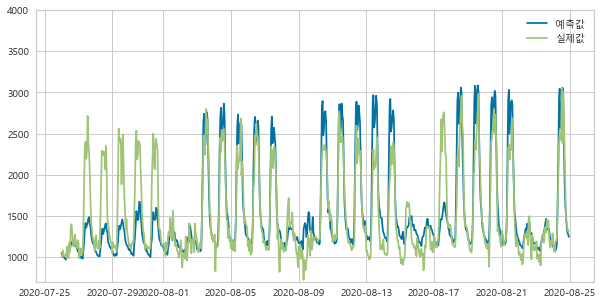

In [263]:
y_real['date_time'] = time.date_time.tolist()
y_real.set_index('date_time', inplace=True)

y_pred['date_time'] = time.date_time.tolist()
y_pred.set_index('date_time', inplace=True)

## 모델링을 위해 log1p 한 y 값을 다시 원래 값으로 변환하여 plot 한다.

fig= plt.figure(figsize=(10,5))

y_1 = np.expm1(y_real)
y_2 = np.expm1(y_pred)

plt.plot(y_1)
plt.ylim(700,4000)
plt.plot(y_2)

plt.legend(['예측값', '실제값'])
plt.show()

나) 특정 일자에서 모델 결과 예측 근거 시각화

In [264]:
row_num = 13

In [265]:
row = X_test.iloc[[row_num]]
row

temp  windspeed  humidity  precipitation  sunshine_hours  Dow  Hour  \
50605  24.0        2.9      95.0            0.2             0.0    5    13   

              HI  temp_grade  CDH  km_cluster(4)  
50605  29.417628           1 -0.0              0

In [266]:
y_test.iloc[[row_num]]

50605    7.205077
Name: powerconsumption, dtype: float64

In [267]:
y_pred = model.predict(row)
y_pred

array([7.2479506], dtype=float32)

In [268]:
## SHAP 활용 시각화

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [269]:
# 100개 테스트 샘플에 대해서 각 특성들의 영향을 봅니다. 
shap_values = explainer.shap_values(X_test.iloc[:192])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[:192])


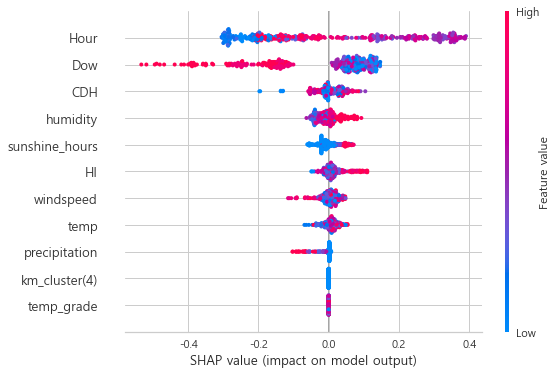

In [270]:
shap_values = explainer.shap_values(X_test.iloc[:])
shap.summary_plot(shap_values, X_test.iloc[:])

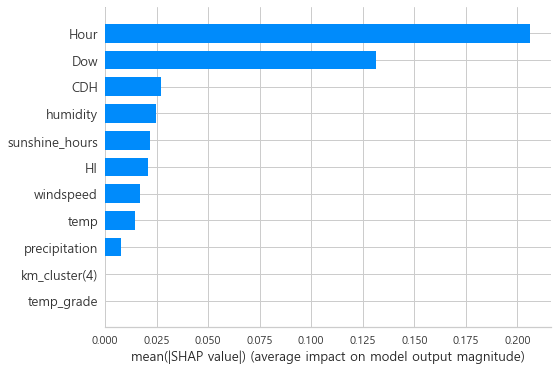

In [271]:
shap.summary_plot(shap_values, X_test.iloc[:], plot_type="bar")

순열중요도 (Permutance Importances)도 구해봅니다.

In [272]:
# permuter 정의
permuter = PermutationImportance(
    model, # model
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=42
)

permuter.fit(X_test, y_test)

feature_names = X_test.columns.to_list()

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)